In [1]:
%load_ext autoreload
%autoreload 2
%cd '/home/xingyu/Projects/PlasticineLab'
%pwd

from plb.envs import make
from imitation.train import get_args
from plb.engine.taichi_env import TaichiEnv
from plb.optimizer.solver import Solver
from plb.algorithms.logger import Logger

device = 'cuda'

log_dir = './data/connect'
args = get_args("")

obs_channel = len(args.img_mode)
img_obs_shape = (args.image_dim, args.image_dim, obs_channel)

args.env_name ='LiftSpread-v1'
env = make(args.env_name)
env.seed(args.seed)
taichi_env: TaichiEnv = env.unwrapped.taichi_env
T = env._max_episode_steps

/home/xingyu/Projects/PlasticineLab
[Taichi] mode=release
[Taichi] preparing sandbox at /tmp/taichi-1kaweqgj
[Taichi] version 0.7.26, llvm 10.0.0, commit e37bdb5e, linux, python 3.8.5
[Taichi] Starting on arch=cuda
[Tina] version 0.1.1
[Tina] Taichi properties hacked
pimirives: num primitive: 3
Building primitive
action:
  dim: 6
  scale: (0.7, 0.005, 0.005, 0.005, 0.0, 0.0)
collision_group: [0.0, 0.0, 0.0]
color: (0.7568, 0.6039, 0.4196)
friction: 0.9
h: 0.3
init_pos: (0.3, 0.25, 0.5)
init_rot: (0.707, 0.707, 0.0, 0.0)
lower_bound: (0.0, 0.09, 0.0)
r: 0.03
shape: RollingPinExt
upper_bound: (1.0, 1.0, 1.0)
variations: None
Building primitive
action:
  dim: 6
  scale: (0.01, 0.01, 0.0, 0.0, 0.0, 0.05)
collision_group: [0, 0, 1]
color: (0.7568, 0.6039, 0.4196)
friction: 50.0
init_pos: (0.65, 0.02, 0.5)
init_rot: (0.707, 0.707, 0.0, 0.0)
lower_bound: (0.0, 0.0, 0.0)
shape: Box
size: (0.1, 0.1, 0.02)
upper_bound: (1.0, 1.0, 1.0)
variations: None
Building primitive
action:
  dim: 0
  scale:

{'init_pos': (0.65, 0.08, 0.5), 'radius': 0.05, 'color': 100}
Env reseting to:  /home/xingyu/Projects/PlasticineLab/plb/envs/../../datasets/0908_LiftSpread/target/target_198.npy
emd after reset: 0.6241204738616943
======================WARNING: contact loss mask not set================


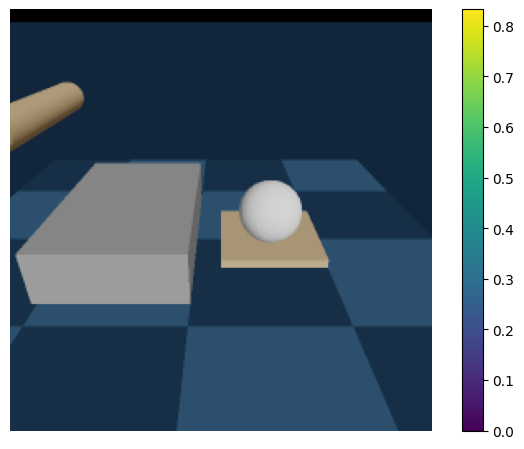

In [6]:
import numpy as np
render_kwargs = {'mode': 'rgb'}

env.generating_cached_state =True
env.reset()
# env.taichi_env.primitives[1].position[0][0] = 0.60
# env.taichi_env.primitives[1].position[0][1] = 0.15
img = taichi_env.render('rgb', img_size=256)
# while (1):
#     env.render('human')
# env.taichi_env.renderer.scene.particle_sdf_raster.sdf_threshold = 0.37 
env.taichi_env.renderer.update_camera(center= (0.5, 0., 0.5),
  theta= 0.,
  phi= -0.88,
  radius= 0.88)
import matplotlib.pyplot as plt
depth = img[:, :, :3]
plt.figure()
plt.imshow(depth)
plt.colorbar()
plt.tight_layout()
plt.axis('off')
plt.show()
# plt.savefig('./etst.png')

{'init_pos': (0.65, 0.08, 0.5), 'radius': 0.05, 'color': 100}
Env reseting to:  /home/xingyu/Projects/PlasticineLab/plb/envs/../../datasets/0908_LiftSpread/target/target_0.npy
emd after reset: 0.3295080065727234
======================WARNING: contact loss mask not set================
MoviePy - Building file data/env_modeling/lift.gif with imageio.


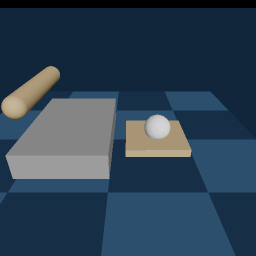

In [3]:
# Generate a lift video
from plb.utils.visualization_utils import save_numpy_as_gif
import numpy as np
filename = 'data/env_modeling/lift.gif'
env.reset(init_v=100, target_v=0)
frames = []
for i in range(10):
    env.step(np.array([0]* 6 + [-0.7, 0.8, 0., 0., 0., 0.2]))
    frames.append(env.taichi_env.render(mode='rgb', img_size=256)[:,:,:3])
for i in range(15):
    env.step(np.array([0]* 6 + [-0.5, 0.8, 0., 0., 0., 0.7]))
    frames.append(env.taichi_env.render(mode='rgb', img_size=256)[:,:,:3])
for i in range(25):
    env.step(np.array([0]* 6 + [1., 0., 0., 0., 0., 0.]))
    frames.append(env.taichi_env.render(mode='rgb', img_size=256)[:,:,:3])
save_numpy_as_gif(np.array(frames), filename)

from IPython.display import Image
Image(filename)
 

In [4]:
from imitation.sampler import sample_traj
from plb.optimizer.solver import Solver
from imitation.utils import to_action_mask
from plb.utils.visualization_utils import save_numpy_as_gif
import numpy as np
reset_key = {'init_v':100,  'target_v':0, 'contact_loss_mask': [0., 0., 0.]}

args.gd_max_iter = 200
args.num_env = 1
for weight in [3e-4, 1e-3, 1e-2, 1e-1, 1]:
    args.energy_weight = weight
    filename = 'data/env_modeling/solve_lift_energy_{}.gif'.format(weight)
    solver = Solver(args, taichi_env, (0,), return_dist=True)

    traj = sample_traj(env, solver, reset_key, action_mask=to_action_mask([0, 1]))

    save_numpy_as_gif(np.array(traj['obses']), filename)

    from IPython.display import Image
    Image(filename)


{'init_pos': (0.65, 0.08, 0.5), 'radius': 0.05, 'color': 100}
Env reseting to:  /home/xingyu/Projects/PlasticineLab/plb/envs/../../datasets/0908_LiftSpread/target/target_0.npy
emd after reset: 0.3295080065727234


  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([50, 12])


0:  16.621444702148438:   0%|          | 1/200 [00:05<17:47,  5.37s/it]

torch.Size([50, 12])


1:  16.2694034576416:   1%|          | 2/200 [00:10<17:07,  5.19s/it]  

torch.Size([50, 12])


2:  15.919734954833984:   2%|▏         | 3/200 [00:15<16:39,  5.07s/it]

torch.Size([50, 12])


3:  15.56274700164795:   2%|▏         | 4/200 [00:20<16:10,  4.95s/it] 

torch.Size([50, 12])


4:  15.16901683807373:   2%|▎         | 5/200 [00:24<15:49,  4.87s/it]

torch.Size([50, 12])


5:  14.742717742919922:   3%|▎         | 6/200 [00:29<15:44,  4.87s/it]

torch.Size([50, 12])


6:  14.310433387756348:   4%|▎         | 7/200 [00:35<16:07,  5.01s/it]

torch.Size([50, 12])


7:  13.876998901367188:   4%|▍         | 8/200 [00:40<16:05,  5.03s/it]

torch.Size([50, 12])


8:  13.556708335876465:   4%|▍         | 9/200 [00:44<15:44,  4.94s/it]

torch.Size([50, 12])


9:  13.292975425720215:   5%|▌         | 10/200 [00:49<15:46,  4.98s/it]

torch.Size([50, 12])


10:  13.145125389099121:   6%|▌         | 11/200 [00:54<15:36,  4.96s/it]

torch.Size([50, 12])


11:  12.966142654418945:   6%|▌         | 12/200 [00:59<15:04,  4.81s/it]

torch.Size([50, 12])


12:  12.787686347961426:   6%|▋         | 13/200 [01:04<15:17,  4.91s/it]

torch.Size([50, 12])


13:  12.606313705444336:   7%|▋         | 14/200 [01:09<15:47,  5.09s/it]

torch.Size([50, 12])


14:  12.625039100646973:   8%|▊         | 15/200 [01:15<16:17,  5.28s/it]

torch.Size([50, 12])


15:  12.54723072052002:   8%|▊         | 16/200 [01:21<16:28,  5.37s/it] 

torch.Size([50, 12])


16:  12.425287246704102:   8%|▊         | 17/200 [01:26<15:59,  5.24s/it]

torch.Size([50, 12])


17:  12.327546119689941:   9%|▉         | 18/200 [01:31<15:55,  5.25s/it]

torch.Size([50, 12])


18:  12.225861549377441:  10%|▉         | 19/200 [01:36<15:41,  5.20s/it]

torch.Size([50, 12])


19:  12.25204086303711:  10%|█         | 20/200 [01:41<15:28,  5.16s/it] 

torch.Size([50, 12])


20:  12.24572467803955:  10%|█         | 21/200 [01:46<15:24,  5.16s/it]

torch.Size([50, 12])


21:  12.23321533203125:  11%|█         | 22/200 [01:52<15:27,  5.21s/it]

torch.Size([50, 12])


22:  12.160299301147461:  12%|█▏        | 23/200 [01:57<15:25,  5.23s/it]

torch.Size([50, 12])


23:  12.0465669631958:  12%|█▏        | 24/200 [02:02<15:02,  5.13s/it]  

torch.Size([50, 12])


24:  12.02707290649414:  12%|█▎        | 25/200 [02:07<14:58,  5.14s/it]

torch.Size([50, 12])


25:  11.926962852478027:  13%|█▎        | 26/200 [02:12<14:55,  5.15s/it]

torch.Size([50, 12])


26:  11.924729347229004:  14%|█▎        | 27/200 [02:17<14:59,  5.20s/it]

torch.Size([50, 12])


27:  11.839982986450195:  14%|█▍        | 28/200 [02:23<15:10,  5.29s/it]

torch.Size([50, 12])


28:  11.853599548339844:  14%|█▍        | 29/200 [02:28<15:11,  5.33s/it]

torch.Size([50, 12])


29:  11.843990325927734:  15%|█▌        | 30/200 [02:34<15:01,  5.30s/it]

torch.Size([50, 12])


30:  11.729243278503418:  16%|█▌        | 31/200 [02:39<14:37,  5.19s/it]

torch.Size([50, 12])


31:  11.678110122680664:  16%|█▌        | 32/200 [02:43<14:08,  5.05s/it]

torch.Size([50, 12])


32:  11.562670707702637:  16%|█▋        | 33/200 [02:48<13:59,  5.03s/it]

torch.Size([50, 12])


33:  11.48635482788086:  17%|█▋        | 34/200 [02:53<13:59,  5.06s/it] 

torch.Size([50, 12])


34:  11.370595932006836:  18%|█▊        | 35/200 [02:58<13:54,  5.06s/it]

torch.Size([50, 12])


35:  11.300539016723633:  18%|█▊        | 36/200 [03:03<13:45,  5.04s/it]

torch.Size([50, 12])


36:  11.161721229553223:  18%|█▊        | 37/200 [03:08<13:17,  4.89s/it]

torch.Size([50, 12])


37:  11.111043930053711:  19%|█▉        | 38/200 [03:12<12:52,  4.77s/it]

torch.Size([50, 12])


38:  11.032177925109863:  20%|█▉        | 39/200 [03:17<12:39,  4.72s/it]

torch.Size([50, 12])


39:  10.96570110321045:  20%|██        | 40/200 [03:22<12:56,  4.86s/it] 

torch.Size([50, 12])


40:  10.869462966918945:  20%|██        | 41/200 [03:27<12:48,  4.83s/it]

torch.Size([50, 12])


41:  10.862222671508789:  21%|██        | 42/200 [03:32<12:29,  4.75s/it]

torch.Size([50, 12])


42:  10.75373363494873:  22%|██▏       | 43/200 [03:36<12:35,  4.81s/it] 

torch.Size([50, 12])


43:  10.732111930847168:  22%|██▏       | 44/200 [03:42<12:53,  4.96s/it]

torch.Size([50, 12])


44:  10.591682434082031:  22%|██▎       | 45/200 [03:47<13:01,  5.04s/it]

torch.Size([50, 12])


45:  10.499712944030762:  23%|██▎       | 46/200 [03:52<13:06,  5.11s/it]

torch.Size([50, 12])


46:  10.410794258117676:  24%|██▎       | 47/200 [03:58<13:08,  5.15s/it]

torch.Size([50, 12])


47:  10.33566665649414:  24%|██▍       | 48/200 [04:03<13:05,  5.17s/it] 

torch.Size([50, 12])


48:  10.263019561767578:  24%|██▍       | 49/200 [04:08<13:02,  5.18s/it]

torch.Size([50, 12])


49:  10.197128295898438:  25%|██▌       | 50/200 [04:13<12:56,  5.18s/it]

torch.Size([50, 12])


50:  10.142440795898438:  26%|██▌       | 51/200 [04:18<12:58,  5.23s/it]

torch.Size([50, 12])


51:  10.049233436584473:  26%|██▌       | 52/200 [04:24<12:54,  5.23s/it]

torch.Size([50, 12])


52:  10.041572570800781:  26%|██▋       | 53/200 [04:28<12:22,  5.05s/it]

torch.Size([50, 12])


53:  9.979969024658203:  27%|██▋       | 54/200 [04:33<12:11,  5.01s/it] 

torch.Size([50, 12])


54:  9.87809944152832:  28%|██▊       | 55/200 [04:38<12:06,  5.01s/it] 

torch.Size([50, 12])


55:  9.887338638305664:  28%|██▊       | 56/200 [04:43<12:07,  5.05s/it]

torch.Size([50, 12])


56:  9.859710693359375:  28%|██▊       | 57/200 [04:48<11:54,  5.00s/it]

torch.Size([50, 12])


57:  9.795331954956055:  29%|██▉       | 58/200 [04:53<11:56,  5.05s/it]

torch.Size([50, 12])


58:  9.828067779541016:  30%|██▉       | 59/200 [04:59<11:52,  5.06s/it]

torch.Size([50, 12])


59:  9.797710418701172:  30%|███       | 60/200 [05:03<11:36,  4.97s/it]

torch.Size([50, 12])


60:  9.738558769226074:  30%|███       | 61/200 [05:08<11:31,  4.97s/it]

torch.Size([50, 12])


61:  9.776729583740234:  31%|███       | 62/200 [05:13<11:15,  4.90s/it]

torch.Size([50, 12])


62:  9.706570625305176:  32%|███▏      | 63/200 [05:18<11:19,  4.96s/it]

torch.Size([50, 12])


63:  9.689945220947266:  32%|███▏      | 64/200 [05:23<11:27,  5.05s/it]

torch.Size([50, 12])


64:  9.65933609008789:  32%|███▎      | 65/200 [05:28<11:23,  5.06s/it] 

torch.Size([50, 12])


65:  9.586878776550293:  33%|███▎      | 66/200 [05:34<11:23,  5.10s/it]

torch.Size([50, 12])


66:  9.579337120056152:  34%|███▎      | 67/200 [05:39<11:23,  5.14s/it]

torch.Size([50, 12])


67:  9.576543807983398:  34%|███▍      | 68/200 [05:44<11:24,  5.18s/it]

torch.Size([50, 12])


68:  9.561450004577637:  34%|███▍      | 69/200 [05:49<11:20,  5.20s/it]

torch.Size([50, 12])


69:  9.43635082244873:  35%|███▌      | 70/200 [05:55<11:13,  5.18s/it] 

torch.Size([50, 12])


70:  9.317219734191895:  36%|███▌      | 71/200 [06:00<11:05,  5.16s/it]

torch.Size([50, 12])


71:  9.38971996307373:  36%|███▌      | 72/200 [06:05<10:56,  5.13s/it] 

torch.Size([50, 12])


72:  9.372613906860352:  36%|███▋      | 73/200 [06:10<10:48,  5.11s/it]

torch.Size([50, 12])


73:  9.2168550491333:  37%|███▋      | 74/200 [06:14<10:19,  4.92s/it]  

torch.Size([50, 12])


74:  9.253753662109375:  38%|███▊      | 75/200 [06:19<10:07,  4.86s/it]

torch.Size([50, 12])


75:  9.21926498413086:  38%|███▊      | 76/200 [06:24<10:13,  4.95s/it] 

torch.Size([50, 12])


76:  9.075424194335938:  38%|███▊      | 77/200 [06:29<10:20,  5.05s/it]

torch.Size([50, 12])


77:  9.156754493713379:  39%|███▉      | 78/200 [06:35<10:18,  5.07s/it]

torch.Size([50, 12])


78:  9.266263008117676:  40%|███▉      | 79/200 [06:40<10:20,  5.13s/it]

torch.Size([50, 12])


79:  9.240206718444824:  40%|████      | 80/200 [06:45<10:23,  5.19s/it]

torch.Size([50, 12])


80:  9.232924461364746:  40%|████      | 81/200 [06:51<10:28,  5.28s/it]

torch.Size([50, 12])


81:  9.299006462097168:  41%|████      | 82/200 [06:56<10:23,  5.28s/it]

torch.Size([50, 12])


82:  9.272326469421387:  42%|████▏     | 83/200 [07:01<09:58,  5.11s/it]

torch.Size([50, 12])


83:  9.264857292175293:  42%|████▏     | 84/200 [07:05<09:30,  4.92s/it]

torch.Size([50, 12])


84:  9.205446243286133:  42%|████▎     | 85/200 [07:10<09:14,  4.82s/it]

torch.Size([50, 12])


85:  9.16673755645752:  43%|████▎     | 86/200 [07:14<09:06,  4.79s/it] 

torch.Size([50, 12])


86:  9.176407814025879:  44%|████▎     | 87/200 [07:19<09:04,  4.82s/it]

torch.Size([50, 12])


87:  9.171733856201172:  44%|████▍     | 88/200 [07:24<09:07,  4.89s/it]

torch.Size([50, 12])


88:  9.111372947692871:  44%|████▍     | 89/200 [07:29<09:07,  4.93s/it]

torch.Size([50, 12])


89:  8.882805824279785:  45%|████▌     | 90/200 [07:34<09:07,  4.97s/it]

torch.Size([50, 12])


90:  8.656878471374512:  46%|████▌     | 91/200 [07:40<09:08,  5.03s/it]

torch.Size([50, 12])


91:  8.492504119873047:  46%|████▌     | 92/200 [07:44<08:48,  4.90s/it]

torch.Size([50, 12])


92:  8.396614074707031:  46%|████▋     | 93/200 [07:49<08:33,  4.80s/it]

torch.Size([50, 12])


93:  8.425857543945312:  47%|████▋     | 94/200 [07:54<08:30,  4.82s/it]

torch.Size([50, 12])


94:  8.427251815795898:  48%|████▊     | 95/200 [07:58<08:17,  4.74s/it]

torch.Size([50, 12])


95:  8.3673677444458:  48%|████▊     | 96/200 [08:03<08:04,  4.66s/it]  

torch.Size([50, 12])


96:  8.309328079223633:  48%|████▊     | 97/200 [08:07<08:00,  4.67s/it]

torch.Size([50, 12])


97:  8.329967498779297:  49%|████▉     | 98/200 [08:12<08:07,  4.78s/it]

torch.Size([50, 12])


98:  8.33551025390625:  50%|████▉     | 99/200 [08:17<08:11,  4.86s/it] 

torch.Size([50, 12])


99:  8.280956268310547:  50%|█████     | 100/200 [08:23<08:13,  4.94s/it]

torch.Size([50, 12])


100:  8.294812202453613:  50%|█████     | 101/200 [08:28<08:16,  5.01s/it]

torch.Size([50, 12])


101:  8.273429870605469:  51%|█████     | 102/200 [08:33<08:14,  5.04s/it]

torch.Size([50, 12])


102:  8.233854293823242:  52%|█████▏    | 103/200 [08:38<08:13,  5.09s/it]

torch.Size([50, 12])


103:  8.225738525390625:  52%|█████▏    | 104/200 [08:43<08:08,  5.09s/it]

torch.Size([50, 12])


104:  8.211357116699219:  52%|█████▎    | 105/200 [08:48<08:02,  5.08s/it]

torch.Size([50, 12])


105:  8.131510734558105:  53%|█████▎    | 106/200 [08:53<08:01,  5.12s/it]

torch.Size([50, 12])


106:  8.20344066619873:  54%|█████▎    | 107/200 [08:58<07:50,  5.06s/it] 

torch.Size([50, 12])


107:  8.119573593139648:  54%|█████▍    | 108/200 [09:03<07:43,  5.04s/it]

torch.Size([50, 12])


108:  8.112122535705566:  55%|█████▍    | 109/200 [09:08<07:41,  5.07s/it]

torch.Size([50, 12])


109:  8.116792678833008:  55%|█████▌    | 110/200 [09:14<07:36,  5.08s/it]

torch.Size([50, 12])


110:  8.082541465759277:  56%|█████▌    | 111/200 [09:19<07:35,  5.12s/it]

torch.Size([50, 12])


111:  8.066892623901367:  56%|█████▌    | 112/200 [09:24<07:31,  5.13s/it]

torch.Size([50, 12])


112:  8.089661598205566:  56%|█████▋    | 113/200 [09:29<07:25,  5.12s/it]

torch.Size([50, 12])


113:  8.138325691223145:  57%|█████▋    | 114/200 [09:34<07:05,  4.95s/it]

torch.Size([50, 12])


114:  8.095281600952148:  57%|█████▊    | 115/200 [09:39<07:01,  4.95s/it]

torch.Size([50, 12])


115:  8.102766036987305:  58%|█████▊    | 116/200 [09:44<07:01,  5.02s/it]

torch.Size([50, 12])


116:  8.071969032287598:  58%|█████▊    | 117/200 [09:49<07:06,  5.14s/it]

torch.Size([50, 12])


117:  8.03923511505127:  59%|█████▉    | 118/200 [09:54<06:55,  5.07s/it] 

torch.Size([50, 12])


118:  8.004900932312012:  60%|█████▉    | 119/200 [09:59<06:38,  4.93s/it]

torch.Size([50, 12])


119:  8.034584045410156:  60%|██████    | 120/200 [10:03<06:30,  4.88s/it]

torch.Size([50, 12])


120:  8.019190788269043:  60%|██████    | 121/200 [10:08<06:28,  4.92s/it]

torch.Size([50, 12])


121:  7.990250587463379:  61%|██████    | 122/200 [10:13<06:12,  4.78s/it]

torch.Size([50, 12])


122:  7.941751480102539:  62%|██████▏   | 123/200 [10:17<06:04,  4.73s/it]

torch.Size([50, 12])


123:  7.994436740875244:  62%|██████▏   | 124/200 [10:23<06:10,  4.87s/it]

torch.Size([50, 12])


124:  7.919439315795898:  62%|██████▎   | 125/200 [10:28<06:10,  4.94s/it]

torch.Size([50, 12])


125:  7.999073028564453:  63%|██████▎   | 126/200 [10:33<06:11,  5.02s/it]

torch.Size([50, 12])


126:  7.985294342041016:  64%|██████▎   | 127/200 [10:38<06:10,  5.07s/it]

torch.Size([50, 12])


127:  7.936046123504639:  64%|██████▍   | 128/200 [10:43<06:06,  5.09s/it]

torch.Size([50, 12])


128:  7.9342803955078125:  64%|██████▍   | 129/200 [10:48<06:02,  5.10s/it]

torch.Size([50, 12])


129:  7.969322681427002:  65%|██████▌   | 130/200 [10:54<05:57,  5.11s/it] 

torch.Size([50, 12])


130:  7.967238426208496:  66%|██████▌   | 131/200 [10:59<05:53,  5.12s/it]

torch.Size([50, 12])


131:  7.849600791931152:  66%|██████▌   | 132/200 [11:04<05:45,  5.09s/it]

torch.Size([50, 12])


132:  7.952589988708496:  66%|██████▋   | 133/200 [11:09<05:42,  5.12s/it]

torch.Size([50, 12])


133:  7.98546838760376:  67%|██████▋   | 134/200 [11:14<05:39,  5.14s/it] 

torch.Size([50, 12])


134:  7.941351890563965:  68%|██████▊   | 135/200 [11:19<05:34,  5.14s/it]

torch.Size([50, 12])


135:  7.896868705749512:  68%|██████▊   | 136/200 [11:24<05:29,  5.15s/it]

torch.Size([50, 12])


136:  7.999029636383057:  68%|██████▊   | 137/200 [11:29<05:22,  5.11s/it]

torch.Size([50, 12])


137:  7.899860858917236:  69%|██████▉   | 138/200 [11:35<05:17,  5.12s/it]

torch.Size([50, 12])


138:  7.944788932800293:  70%|██████▉   | 139/200 [11:40<05:15,  5.16s/it]

torch.Size([50, 12])


139:  7.905433177947998:  70%|███████   | 140/200 [11:45<05:09,  5.15s/it]

torch.Size([50, 12])


140:  7.918991565704346:  70%|███████   | 141/200 [11:50<05:01,  5.11s/it]

torch.Size([50, 12])


141:  7.856078624725342:  71%|███████   | 142/200 [11:55<05:00,  5.18s/it]

torch.Size([50, 12])


142:  7.886877536773682:  72%|███████▏  | 143/200 [12:00<04:52,  5.13s/it]

torch.Size([50, 12])


143:  7.903107643127441:  72%|███████▏  | 144/200 [12:05<04:45,  5.10s/it]

torch.Size([50, 12])


144:  7.890895366668701:  72%|███████▎  | 145/200 [12:11<04:41,  5.12s/it]

torch.Size([50, 12])


145:  7.899985313415527:  73%|███████▎  | 146/200 [12:16<04:37,  5.14s/it]

torch.Size([50, 12])


146:  7.901352882385254:  74%|███████▎  | 147/200 [12:21<04:32,  5.14s/it]

torch.Size([50, 12])


147:  7.901029109954834:  74%|███████▍  | 148/200 [12:26<04:27,  5.14s/it]

torch.Size([50, 12])


148:  7.898892879486084:  74%|███████▍  | 149/200 [12:31<04:22,  5.14s/it]

torch.Size([50, 12])


149:  7.917117595672607:  75%|███████▌  | 150/200 [12:37<04:20,  5.22s/it]

torch.Size([50, 12])


150:  7.848882675170898:  76%|███████▌  | 151/200 [12:42<04:14,  5.19s/it]

torch.Size([50, 12])


151:  7.862360954284668:  76%|███████▌  | 152/200 [12:47<04:08,  5.18s/it]

torch.Size([50, 12])


152:  7.8912835121154785:  76%|███████▋  | 153/200 [12:52<04:02,  5.16s/it]

torch.Size([50, 12])


153:  7.799806118011475:  77%|███████▋  | 154/200 [12:57<03:50,  5.00s/it] 

torch.Size([50, 12])


154:  7.8532633781433105:  78%|███████▊  | 155/200 [13:02<03:44,  4.99s/it]

torch.Size([50, 12])


155:  7.975630283355713:  78%|███████▊  | 156/200 [13:06<03:35,  4.89s/it] 

torch.Size([50, 12])


156:  7.884852886199951:  78%|███████▊  | 157/200 [13:11<03:25,  4.79s/it]

torch.Size([50, 12])


157:  7.9820122718811035:  79%|███████▉  | 158/200 [13:16<03:21,  4.80s/it]

torch.Size([50, 12])


158:  7.97555685043335:  80%|███████▉  | 159/200 [13:20<03:17,  4.82s/it]  

torch.Size([50, 12])


159:  8.04250717163086:  80%|████████  | 160/200 [13:26<03:17,  4.93s/it]

torch.Size([50, 12])


160:  8.096407890319824:  80%|████████  | 161/200 [13:31<03:14,  4.98s/it]

torch.Size([50, 12])


161:  8.041399002075195:  81%|████████  | 162/200 [13:36<03:11,  5.05s/it]

torch.Size([50, 12])


162:  8.095401763916016:  82%|████████▏ | 163/200 [13:41<03:07,  5.06s/it]

torch.Size([50, 12])


163:  8.164834976196289:  82%|████████▏ | 164/200 [13:46<02:58,  4.95s/it]

torch.Size([50, 12])


164:  8.069709777832031:  82%|████████▎ | 165/200 [13:51<02:51,  4.91s/it]

torch.Size([50, 12])


165:  8.075837135314941:  83%|████████▎ | 166/200 [13:56<02:49,  4.99s/it]

torch.Size([50, 12])


166:  8.076865196228027:  84%|████████▎ | 167/200 [14:01<02:47,  5.07s/it]

torch.Size([50, 12])


167:  8.034706115722656:  84%|████████▍ | 168/200 [14:06<02:42,  5.09s/it]

torch.Size([50, 12])


168:  8.016312599182129:  84%|████████▍ | 169/200 [14:11<02:38,  5.13s/it]

torch.Size([50, 12])


169:  7.964898109436035:  85%|████████▌ | 170/200 [14:16<02:31,  5.06s/it]

torch.Size([50, 12])


170:  7.939476490020752:  86%|████████▌ | 171/200 [14:21<02:28,  5.12s/it]

torch.Size([50, 12])


171:  7.873775959014893:  86%|████████▌ | 172/200 [14:27<02:23,  5.13s/it]

torch.Size([50, 12])


172:  7.953192234039307:  86%|████████▋ | 173/200 [14:32<02:18,  5.12s/it]

torch.Size([50, 12])


173:  7.87465238571167:  87%|████████▋ | 174/200 [14:37<02:13,  5.12s/it] 

torch.Size([50, 12])


174:  7.905132293701172:  88%|████████▊ | 175/200 [14:42<02:08,  5.12s/it]

torch.Size([50, 12])


175:  7.889708042144775:  88%|████████▊ | 176/200 [14:47<02:02,  5.11s/it]

torch.Size([50, 12])


176:  9.327574729919434:  88%|████████▊ | 177/200 [14:52<01:57,  5.12s/it]

torch.Size([50, 12])


177:  9.384600639343262:  89%|████████▉ | 178/200 [14:57<01:53,  5.17s/it]

torch.Size([50, 12])


178:  9.307056427001953:  90%|████████▉ | 179/200 [15:03<01:49,  5.23s/it]

torch.Size([50, 12])


179:  9.212631225585938:  90%|█████████ | 180/200 [15:08<01:44,  5.24s/it]

torch.Size([50, 12])


180:  9.083925247192383:  90%|█████████ | 181/200 [15:13<01:39,  5.23s/it]

torch.Size([50, 12])


181:  8.39822769165039:  91%|█████████ | 182/200 [15:18<01:33,  5.18s/it] 

torch.Size([50, 12])


182:  8.288247108459473:  92%|█████████▏| 183/200 [15:23<01:27,  5.13s/it]

torch.Size([50, 12])


183:  8.303816795349121:  92%|█████████▏| 184/200 [15:28<01:19,  4.99s/it]

torch.Size([50, 12])


184:  8.238224983215332:  92%|█████████▎| 185/200 [15:33<01:12,  4.83s/it]

torch.Size([50, 12])


185:  8.149595260620117:  93%|█████████▎| 186/200 [15:37<01:06,  4.76s/it]

torch.Size([50, 12])


186:  8.205527305603027:  94%|█████████▎| 187/200 [15:42<01:01,  4.72s/it]

torch.Size([50, 12])


187:  8.247933387756348:  94%|█████████▍| 188/200 [15:46<00:55,  4.65s/it]

torch.Size([50, 12])


188:  8.294548988342285:  94%|█████████▍| 189/200 [15:51<00:50,  4.59s/it]

torch.Size([50, 12])


189:  8.312575340270996:  95%|█████████▌| 190/200 [15:55<00:45,  4.56s/it]

torch.Size([50, 12])


190:  8.294088363647461:  96%|█████████▌| 191/200 [16:00<00:41,  4.58s/it]

torch.Size([50, 12])


191:  8.360390663146973:  96%|█████████▌| 192/200 [16:04<00:36,  4.59s/it]

torch.Size([50, 12])


192:  8.32163143157959:  96%|█████████▋| 193/200 [16:09<00:32,  4.58s/it] 

torch.Size([50, 12])


193:  8.422653198242188:  97%|█████████▋| 194/200 [16:14<00:27,  4.58s/it]

torch.Size([50, 12])


194:  8.431062698364258:  98%|█████████▊| 195/200 [16:18<00:23,  4.61s/it]

torch.Size([50, 12])


195:  8.404162406921387:  98%|█████████▊| 196/200 [16:23<00:18,  4.74s/it]

torch.Size([50, 12])


196:  8.416683197021484:  98%|█████████▊| 197/200 [16:28<00:14,  4.87s/it]

torch.Size([50, 12])


197:  8.47414493560791:  99%|█████████▉| 198/200 [16:33<00:09,  4.92s/it] 

torch.Size([50, 12])


198:  8.479087829589844: 100%|█████████▉| 199/200 [16:39<00:04,  4.97s/it]

torch.Size([50, 12])


199:  8.475475311279297: 100%|██████████| 200/200 [16:43<00:00,  5.02s/it]


MoviePy - Building file data/env_modeling/solve_lift_energy_0.0003.gif with imageio.


{'init_pos': (0.65, 0.08, 0.5), 'radius': 0.05, 'color': 100}
Env reseting to:  /home/xingyu/Projects/PlasticineLab/plb/envs/../../datasets/0908_LiftSpread/target/target_0.npy
emd after reset: 0.3295080065727234


  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([50, 12])


0:  16.622034072875977:   0%|          | 1/200 [00:05<16:40,  5.03s/it]

torch.Size([50, 12])


1:  16.269777297973633:   1%|          | 2/200 [00:10<16:37,  5.04s/it]

torch.Size([50, 12])


2:  15.918800354003906:   2%|▏         | 3/200 [00:14<16:07,  4.91s/it]

torch.Size([50, 12])


3:  15.557148933410645:   2%|▏         | 4/200 [00:19<16:14,  4.97s/it]

torch.Size([50, 12])


4:  15.180093765258789:   2%|▎         | 5/200 [00:24<16:14,  5.00s/it]

torch.Size([50, 12])


5:  14.781123161315918:   3%|▎         | 6/200 [00:30<16:14,  5.02s/it]

torch.Size([50, 12])


6:  14.40101146697998:   4%|▎         | 7/200 [00:35<16:18,  5.07s/it] 

torch.Size([50, 12])


7:  13.924938201904297:   4%|▍         | 8/200 [00:40<16:15,  5.08s/it]

torch.Size([50, 12])


8:  13.557112693786621:   4%|▍         | 9/200 [00:45<16:17,  5.12s/it]

torch.Size([50, 12])


9:  13.345656394958496:   5%|▌         | 10/200 [00:50<16:08,  5.10s/it]

torch.Size([50, 12])


10:  13.153270721435547:   6%|▌         | 11/200 [00:55<16:05,  5.11s/it]

torch.Size([50, 12])


11:  12.939717292785645:   6%|▌         | 12/200 [01:00<16:05,  5.13s/it]

torch.Size([50, 12])


12:  12.765005111694336:   6%|▋         | 13/200 [01:05<15:52,  5.09s/it]

torch.Size([50, 12])


13:  12.686894416809082:   7%|▋         | 14/200 [01:10<15:39,  5.05s/it]

torch.Size([50, 12])


14:  12.528082847595215:   8%|▊         | 15/200 [01:15<15:02,  4.88s/it]

torch.Size([50, 12])


15:  12.477717399597168:   8%|▊         | 16/200 [01:19<14:29,  4.72s/it]

torch.Size([50, 12])


16:  12.376415252685547:   8%|▊         | 17/200 [01:24<14:04,  4.62s/it]

torch.Size([50, 12])


17:  12.413289070129395:   9%|▉         | 18/200 [01:28<13:52,  4.58s/it]

torch.Size([50, 12])


18:  12.336633682250977:  10%|▉         | 19/200 [01:33<13:47,  4.57s/it]

torch.Size([50, 12])


19:  12.315427780151367:  10%|█         | 20/200 [01:37<13:57,  4.65s/it]

torch.Size([50, 12])


20:  12.301590919494629:  10%|█         | 21/200 [01:42<14:13,  4.77s/it]

torch.Size([50, 12])


21:  12.226096153259277:  11%|█         | 22/200 [01:47<13:58,  4.71s/it]

torch.Size([50, 12])


22:  12.17440414428711:  12%|█▏        | 23/200 [01:52<13:49,  4.69s/it] 

torch.Size([50, 12])


23:  12.125336647033691:  12%|█▏        | 24/200 [01:57<14:02,  4.79s/it]

torch.Size([50, 12])


24:  12.043990135192871:  12%|█▎        | 25/200 [02:02<14:21,  4.92s/it]

torch.Size([50, 12])


25:  12.003416061401367:  13%|█▎        | 26/200 [02:07<14:04,  4.86s/it]

torch.Size([50, 12])


26:  11.895302772521973:  14%|█▎        | 27/200 [02:11<13:59,  4.85s/it]

torch.Size([50, 12])


27:  11.852065086364746:  14%|█▍        | 28/200 [02:16<13:46,  4.80s/it]

torch.Size([50, 12])


28:  11.891215324401855:  14%|█▍        | 29/200 [02:21<13:56,  4.89s/it]

torch.Size([50, 12])


29:  11.880289077758789:  15%|█▌        | 30/200 [02:26<14:05,  4.97s/it]

torch.Size([50, 12])


30:  11.783872604370117:  16%|█▌        | 31/200 [02:32<14:06,  5.01s/it]

torch.Size([50, 12])


31:  11.673054695129395:  16%|█▌        | 32/200 [02:37<14:07,  5.05s/it]

torch.Size([50, 12])


32:  11.579596519470215:  16%|█▋        | 33/200 [02:42<14:03,  5.05s/it]

torch.Size([50, 12])


33:  11.5064115524292:  17%|█▋        | 34/200 [02:46<13:34,  4.91s/it]  

torch.Size([50, 12])


34:  11.401594161987305:  18%|█▊        | 35/200 [02:51<13:19,  4.85s/it]

torch.Size([50, 12])


35:  11.374992370605469:  18%|█▊        | 36/200 [02:56<13:07,  4.80s/it]

torch.Size([50, 12])


36:  11.248618125915527:  18%|█▊        | 37/200 [03:00<12:53,  4.74s/it]

torch.Size([50, 12])


37:  11.179518699645996:  19%|█▉        | 38/200 [03:05<12:40,  4.69s/it]

torch.Size([50, 12])


38:  11.097469329833984:  20%|█▉        | 39/200 [03:10<12:53,  4.81s/it]

torch.Size([50, 12])


39:  11.0842866897583:  20%|██        | 40/200 [03:15<13:09,  4.94s/it]  

torch.Size([50, 12])


40:  10.975255966186523:  20%|██        | 41/200 [03:20<12:59,  4.90s/it]

torch.Size([50, 12])


41:  10.92794132232666:  21%|██        | 42/200 [03:25<12:45,  4.84s/it] 

torch.Size([50, 12])


42:  10.853948593139648:  22%|██▏       | 43/200 [03:29<12:29,  4.77s/it]

torch.Size([50, 12])


43:  10.78002643585205:  22%|██▏       | 44/200 [03:34<12:17,  4.73s/it] 

torch.Size([50, 12])


44:  10.784805297851562:  22%|██▎       | 45/200 [03:38<12:01,  4.66s/it]

torch.Size([50, 12])


45:  10.66876220703125:  23%|██▎       | 46/200 [03:43<11:50,  4.61s/it] 

torch.Size([50, 12])


46:  10.66507339477539:  24%|██▎       | 47/200 [03:47<11:40,  4.58s/it]

torch.Size([50, 12])


47:  10.550542831420898:  24%|██▍       | 48/200 [03:52<11:37,  4.59s/it]

torch.Size([50, 12])


48:  10.452757835388184:  24%|██▍       | 49/200 [03:57<11:28,  4.56s/it]

torch.Size([50, 12])


49:  10.35354995727539:  25%|██▌       | 50/200 [04:01<11:18,  4.53s/it] 

torch.Size([50, 12])


50:  10.265501022338867:  26%|██▌       | 51/200 [04:06<11:13,  4.52s/it]

torch.Size([50, 12])


51:  10.324607849121094:  26%|██▌       | 52/200 [04:10<11:14,  4.55s/it]

torch.Size([50, 12])


52:  10.305278778076172:  26%|██▋       | 53/200 [04:15<11:15,  4.60s/it]

torch.Size([50, 12])


53:  10.211488723754883:  27%|██▋       | 54/200 [04:20<11:19,  4.65s/it]

torch.Size([50, 12])


54:  9.979162216186523:  28%|██▊       | 55/200 [04:24<11:15,  4.66s/it] 

torch.Size([50, 12])


55:  10.01138973236084:  28%|██▊       | 56/200 [04:29<11:06,  4.63s/it]

torch.Size([50, 12])


56:  9.993303298950195:  28%|██▊       | 57/200 [04:33<10:59,  4.61s/it]

torch.Size([50, 12])


57:  10.030755996704102:  29%|██▉       | 58/200 [04:38<10:52,  4.59s/it]

torch.Size([50, 12])


58:  9.891897201538086:  30%|██▉       | 59/200 [04:42<10:44,  4.57s/it] 

torch.Size([50, 12])


59:  9.862077713012695:  30%|███       | 60/200 [04:47<10:36,  4.55s/it]

torch.Size([50, 12])


60:  9.791814804077148:  30%|███       | 61/200 [04:52<10:31,  4.54s/it]

torch.Size([50, 12])


61:  9.745356559753418:  31%|███       | 62/200 [04:56<10:30,  4.57s/it]

torch.Size([50, 12])


62:  9.799081802368164:  32%|███▏      | 63/200 [05:01<10:43,  4.70s/it]

torch.Size([50, 12])


63:  9.775725364685059:  32%|███▏      | 64/200 [05:06<10:55,  4.82s/it]

torch.Size([50, 12])


64:  9.780595779418945:  32%|███▎      | 65/200 [05:11<11:02,  4.91s/it]

torch.Size([50, 12])


65:  9.791864395141602:  33%|███▎      | 66/200 [05:16<11:04,  4.96s/it]

torch.Size([50, 12])


66:  9.714107513427734:  34%|███▎      | 67/200 [05:22<11:06,  5.01s/it]

torch.Size([50, 12])


67:  9.658767700195312:  34%|███▍      | 68/200 [05:27<11:03,  5.02s/it]

torch.Size([50, 12])


68:  9.793815612792969:  34%|███▍      | 69/200 [05:32<11:01,  5.05s/it]

torch.Size([50, 12])


69:  9.759572982788086:  35%|███▌      | 70/200 [05:37<10:53,  5.03s/it]

torch.Size([50, 12])


70:  9.68547248840332:  36%|███▌      | 71/200 [05:42<10:39,  4.96s/it] 

torch.Size([50, 12])


71:  9.790426254272461:  36%|███▌      | 72/200 [05:46<10:20,  4.85s/it]

torch.Size([50, 12])


72:  9.663065910339355:  36%|███▋      | 73/200 [05:51<10:21,  4.89s/it]

torch.Size([50, 12])


73:  9.669578552246094:  37%|███▋      | 74/200 [05:56<10:01,  4.77s/it]

torch.Size([50, 12])


74:  9.637813568115234:  38%|███▊      | 75/200 [06:00<09:48,  4.71s/it]

torch.Size([50, 12])


75:  9.62696647644043:  38%|███▊      | 76/200 [06:05<09:34,  4.63s/it] 

torch.Size([50, 12])


76:  9.626222610473633:  38%|███▊      | 77/200 [06:10<09:39,  4.71s/it]

torch.Size([50, 12])


77:  9.54958724975586:  39%|███▉      | 78/200 [06:15<09:51,  4.85s/it] 

torch.Size([50, 12])


78:  9.647772789001465:  40%|███▉      | 79/200 [06:19<09:36,  4.76s/it]

torch.Size([50, 12])


79:  9.626875877380371:  40%|████      | 80/200 [06:24<09:32,  4.77s/it]

torch.Size([50, 12])


80:  9.573690414428711:  40%|████      | 81/200 [06:29<09:38,  4.86s/it]

torch.Size([50, 12])


81:  9.587149620056152:  41%|████      | 82/200 [06:34<09:41,  4.93s/it]

torch.Size([50, 12])


82:  9.580815315246582:  42%|████▏     | 83/200 [06:39<09:40,  4.97s/it]

torch.Size([50, 12])


83:  9.491558074951172:  42%|████▏     | 84/200 [06:44<09:46,  5.05s/it]

torch.Size([50, 12])


84:  9.476666450500488:  42%|████▎     | 85/200 [06:49<09:29,  4.95s/it]

torch.Size([50, 12])


85:  9.407072067260742:  43%|████▎     | 86/200 [06:54<09:21,  4.92s/it]

torch.Size([50, 12])


86:  9.491260528564453:  44%|████▎     | 87/200 [06:59<09:22,  4.98s/it]

torch.Size([50, 12])


87:  9.529202461242676:  44%|████▍     | 88/200 [07:04<09:17,  4.98s/it]

torch.Size([50, 12])


88:  9.40908145904541:  44%|████▍     | 89/200 [07:09<09:10,  4.96s/it] 

torch.Size([50, 12])


89:  9.390772819519043:  45%|████▌     | 90/200 [07:14<08:51,  4.84s/it]

torch.Size([50, 12])


90:  9.404297828674316:  46%|████▌     | 91/200 [07:19<08:52,  4.89s/it]

torch.Size([50, 12])


91:  9.391382217407227:  46%|████▌     | 92/200 [07:24<08:56,  4.97s/it]

torch.Size([50, 12])


92:  9.364386558532715:  46%|████▋     | 93/200 [07:29<09:01,  5.06s/it]

torch.Size([50, 12])


93:  9.360849380493164:  47%|████▋     | 94/200 [07:34<09:00,  5.10s/it]

torch.Size([50, 12])


94:  9.250466346740723:  48%|████▊     | 95/200 [07:39<08:54,  5.09s/it]

torch.Size([50, 12])


95:  9.326150894165039:  48%|████▊     | 96/200 [07:44<08:51,  5.11s/it]

torch.Size([50, 12])


96:  9.361974716186523:  48%|████▊     | 97/200 [07:50<08:47,  5.12s/it]

torch.Size([50, 12])


97:  9.261859893798828:  49%|████▉     | 98/200 [07:55<08:37,  5.08s/it]

torch.Size([50, 12])


98:  9.265427589416504:  50%|████▉     | 99/200 [08:00<08:34,  5.10s/it]

torch.Size([50, 12])


99:  9.169303894042969:  50%|█████     | 100/200 [08:05<08:31,  5.12s/it]

torch.Size([50, 12])


100:  9.159811973571777:  50%|█████     | 101/200 [08:10<08:26,  5.11s/it]

torch.Size([50, 12])


101:  9.215197563171387:  51%|█████     | 102/200 [08:15<08:16,  5.06s/it]

torch.Size([50, 12])


102:  9.150216102600098:  52%|█████▏    | 103/200 [08:20<08:09,  5.05s/it]

torch.Size([50, 12])


103:  9.153764724731445:  52%|█████▏    | 104/200 [08:25<08:09,  5.10s/it]

torch.Size([50, 12])


104:  9.187336921691895:  52%|█████▎    | 105/200 [08:30<08:09,  5.15s/it]

torch.Size([50, 12])


105:  9.17025375366211:  53%|█████▎    | 106/200 [08:36<08:08,  5.20s/it] 

torch.Size([50, 12])


106:  9.132845878601074:  54%|█████▎    | 107/200 [08:41<08:01,  5.17s/it]

torch.Size([50, 12])


107:  9.177689552307129:  54%|█████▍    | 108/200 [08:46<07:53,  5.15s/it]

torch.Size([50, 12])


108:  9.102296829223633:  55%|█████▍    | 109/200 [08:51<07:45,  5.11s/it]

torch.Size([50, 12])


109:  8.954275131225586:  55%|█████▌    | 110/200 [08:56<07:34,  5.05s/it]

torch.Size([50, 12])


110:  8.827227592468262:  56%|█████▌    | 111/200 [09:00<07:17,  4.92s/it]

torch.Size([50, 12])


111:  8.625273704528809:  56%|█████▌    | 112/200 [09:05<07:11,  4.91s/it]

torch.Size([50, 12])


112:  8.481231689453125:  56%|█████▋    | 113/200 [09:10<07:01,  4.84s/it]

torch.Size([50, 12])


113:  8.478202819824219:  57%|█████▋    | 114/200 [09:15<06:58,  4.87s/it]

torch.Size([50, 12])


114:  8.560785293579102:  57%|█████▊    | 115/200 [09:20<06:46,  4.78s/it]

torch.Size([50, 12])


115:  8.46002197265625:  58%|█████▊    | 116/200 [09:24<06:35,  4.71s/it] 

torch.Size([50, 12])


116:  8.472329139709473:  58%|█████▊    | 117/200 [09:29<06:34,  4.75s/it]

torch.Size([50, 12])


117:  8.363144874572754:  59%|█████▉    | 118/200 [09:34<06:39,  4.87s/it]

torch.Size([50, 12])


118:  8.355648040771484:  60%|█████▉    | 119/200 [09:39<06:43,  4.98s/it]

torch.Size([50, 12])


119:  8.322909355163574:  60%|██████    | 120/200 [09:44<06:42,  5.03s/it]

torch.Size([50, 12])


120:  8.351576805114746:  60%|██████    | 121/200 [09:50<06:38,  5.05s/it]

torch.Size([50, 12])


121:  8.317888259887695:  61%|██████    | 122/200 [09:55<06:35,  5.08s/it]

torch.Size([50, 12])


122:  8.367030143737793:  62%|██████▏   | 123/200 [10:00<06:27,  5.03s/it]

torch.Size([50, 12])


123:  8.296661376953125:  62%|██████▏   | 124/200 [10:04<06:12,  4.91s/it]

torch.Size([50, 12])


124:  8.315979957580566:  62%|██████▎   | 125/200 [10:09<06:08,  4.92s/it]

torch.Size([50, 12])


125:  8.250432014465332:  63%|██████▎   | 126/200 [10:14<05:54,  4.79s/it]

torch.Size([50, 12])


126:  8.258891105651855:  64%|██████▎   | 127/200 [10:18<05:46,  4.75s/it]

torch.Size([50, 12])


127:  8.253911018371582:  64%|██████▍   | 128/200 [10:23<05:36,  4.67s/it]

torch.Size([50, 12])


128:  8.236952781677246:  64%|██████▍   | 129/200 [10:27<05:30,  4.66s/it]

torch.Size([50, 12])


129:  8.201154708862305:  65%|██████▌   | 130/200 [10:33<05:34,  4.78s/it]

torch.Size([50, 12])


130:  8.255329132080078:  66%|██████▌   | 131/200 [10:37<05:30,  4.79s/it]

torch.Size([50, 12])


131:  8.266544342041016:  66%|██████▌   | 132/200 [10:43<05:33,  4.90s/it]

torch.Size([50, 12])


132:  8.19007682800293:  66%|██████▋   | 133/200 [10:48<05:31,  4.94s/it] 

torch.Size([50, 12])


133:  8.246588706970215:  67%|██████▋   | 134/200 [10:53<05:31,  5.02s/it]

torch.Size([50, 12])


134:  8.190896987915039:  68%|██████▊   | 135/200 [10:58<05:25,  5.01s/it]

torch.Size([50, 12])


135:  8.203887939453125:  68%|██████▊   | 136/200 [11:03<05:17,  4.97s/it]

torch.Size([50, 12])


136:  8.185473442077637:  68%|██████▊   | 137/200 [11:08<05:15,  5.00s/it]

torch.Size([50, 12])


137:  8.162836074829102:  69%|██████▉   | 138/200 [11:13<05:12,  5.04s/it]

torch.Size([50, 12])


138:  8.14665699005127:  70%|██████▉   | 139/200 [11:18<05:07,  5.04s/it] 

torch.Size([50, 12])


139:  8.138093948364258:  70%|███████   | 140/200 [11:23<05:04,  5.07s/it]

torch.Size([50, 12])


140:  8.13927936553955:  70%|███████   | 141/200 [11:28<05:00,  5.10s/it] 

torch.Size([50, 12])


141:  9.404243469238281:  71%|███████   | 142/200 [11:33<04:51,  5.03s/it]

torch.Size([50, 12])


142:  9.359978675842285:  72%|███████▏  | 143/200 [11:38<04:46,  5.03s/it]

torch.Size([50, 12])


143:  9.391030311584473:  72%|███████▏  | 144/200 [11:43<04:45,  5.09s/it]

torch.Size([50, 12])


144:  9.322458267211914:  72%|███████▎  | 145/200 [11:48<04:31,  4.93s/it]

torch.Size([50, 12])


145:  9.300409317016602:  73%|███████▎  | 146/200 [11:53<04:21,  4.85s/it]

torch.Size([50, 12])


146:  9.103105545043945:  74%|███████▎  | 147/200 [11:58<04:21,  4.93s/it]

torch.Size([50, 12])


147:  8.7582426071167:  74%|███████▍  | 148/200 [12:03<04:21,  5.03s/it]  

torch.Size([50, 12])


148:  9.546521186828613:  74%|███████▍  | 149/200 [12:08<04:17,  5.06s/it]

torch.Size([50, 12])


149:  9.489782333374023:  75%|███████▌  | 150/200 [12:13<04:09,  4.99s/it]

torch.Size([50, 12])


150:  9.430634498596191:  76%|███████▌  | 151/200 [12:17<03:58,  4.87s/it]

torch.Size([50, 12])


151:  8.597084999084473:  76%|███████▌  | 152/200 [12:22<03:49,  4.78s/it]

torch.Size([50, 12])


152:  9.772272109985352:  76%|███████▋  | 153/200 [12:27<03:50,  4.91s/it]

torch.Size([50, 12])


153:  9.418841361999512:  77%|███████▋  | 154/200 [12:32<03:46,  4.92s/it]

torch.Size([50, 12])


154:  8.6612548828125:  78%|███████▊  | 155/200 [12:37<03:42,  4.94s/it]  

torch.Size([50, 12])


155:  8.636698722839355:  78%|███████▊  | 156/200 [12:42<03:42,  5.06s/it]

torch.Size([50, 12])


156:  8.381003379821777:  78%|███████▊  | 157/200 [12:48<03:41,  5.16s/it]

torch.Size([50, 12])


157:  8.350814819335938:  79%|███████▉  | 158/200 [12:53<03:38,  5.19s/it]

torch.Size([50, 12])


158:  8.33548641204834:  80%|███████▉  | 159/200 [12:58<03:33,  5.21s/it] 

torch.Size([50, 12])


159:  8.396130561828613:  80%|████████  | 160/200 [13:04<03:28,  5.22s/it]

torch.Size([50, 12])


160:  8.464496612548828:  80%|████████  | 161/200 [13:09<03:23,  5.21s/it]

torch.Size([50, 12])


161:  8.420385360717773:  81%|████████  | 162/200 [13:14<03:18,  5.23s/it]

torch.Size([50, 12])


162:  8.366140365600586:  82%|████████▏ | 163/200 [13:19<03:13,  5.24s/it]

torch.Size([50, 12])


163:  8.411468505859375:  82%|████████▏ | 164/200 [13:25<03:08,  5.24s/it]

torch.Size([50, 12])


164:  8.442302703857422:  82%|████████▎ | 165/200 [13:30<03:01,  5.18s/it]

torch.Size([50, 12])


165:  8.387754440307617:  83%|████████▎ | 166/200 [13:35<02:57,  5.21s/it]

torch.Size([50, 12])


166:  8.414222717285156:  84%|████████▎ | 167/200 [13:40<02:50,  5.17s/it]

torch.Size([50, 12])


167:  8.418083190917969:  84%|████████▍ | 168/200 [13:45<02:44,  5.15s/it]

torch.Size([50, 12])


168:  8.398035049438477:  84%|████████▍ | 169/200 [13:50<02:37,  5.08s/it]

torch.Size([50, 12])


169:  8.356388092041016:  85%|████████▌ | 170/200 [13:55<02:32,  5.07s/it]

torch.Size([50, 12])


170:  8.413443565368652:  86%|████████▌ | 171/200 [14:00<02:29,  5.15s/it]

torch.Size([50, 12])


171:  8.326298713684082:  86%|████████▌ | 172/200 [14:06<02:26,  5.23s/it]

torch.Size([50, 12])


172:  8.39855670928955:  86%|████████▋ | 173/200 [14:11<02:20,  5.22s/it] 

torch.Size([50, 12])


173:  8.321081161499023:  87%|████████▋ | 174/200 [14:16<02:12,  5.09s/it]

torch.Size([50, 12])


174:  8.343697547912598:  88%|████████▊ | 175/200 [14:21<02:05,  5.03s/it]

torch.Size([50, 12])


175:  8.410149574279785:  88%|████████▊ | 176/200 [14:26<02:00,  5.02s/it]

torch.Size([50, 12])


176:  8.351202964782715:  88%|████████▊ | 177/200 [14:30<01:51,  4.86s/it]

torch.Size([50, 12])


177:  8.379551887512207:  89%|████████▉ | 178/200 [14:35<01:49,  5.00s/it]

torch.Size([50, 12])


178:  8.3207426071167:  90%|████████▉ | 179/200 [14:40<01:43,  4.92s/it]  

torch.Size([50, 12])


179:  8.34228229522705:  90%|█████████ | 180/200 [14:45<01:36,  4.84s/it]

torch.Size([50, 12])


180:  8.552903175354004:  90%|█████████ | 181/200 [14:50<01:34,  4.96s/it]

torch.Size([50, 12])


181:  8.505805015563965:  91%|█████████ | 182/200 [14:56<01:31,  5.10s/it]

torch.Size([50, 12])


182:  8.478676795959473:  92%|█████████▏| 183/200 [15:01<01:27,  5.15s/it]

torch.Size([50, 12])


183:  8.474109649658203:  92%|█████████▏| 184/200 [15:06<01:22,  5.13s/it]

torch.Size([50, 12])


184:  8.504565238952637:  92%|█████████▎| 185/200 [15:11<01:16,  5.08s/it]

torch.Size([50, 12])


185:  8.485918045043945:  93%|█████████▎| 186/200 [15:16<01:10,  5.05s/it]

torch.Size([50, 12])


186:  8.483423233032227:  94%|█████████▎| 187/200 [15:21<01:04,  4.97s/it]

torch.Size([50, 12])


187:  8.468339920043945:  94%|█████████▍| 188/200 [15:25<00:57,  4.82s/it]

torch.Size([50, 12])


188:  8.466992378234863:  94%|█████████▍| 189/200 [15:30<00:52,  4.81s/it]

torch.Size([50, 12])


189:  8.473447799682617:  95%|█████████▌| 190/200 [15:35<00:48,  4.86s/it]

torch.Size([50, 12])


190:  8.426153182983398:  96%|█████████▌| 191/200 [15:39<00:42,  4.77s/it]

torch.Size([50, 12])


191:  8.30251693725586:  96%|█████████▌| 192/200 [15:45<00:39,  4.89s/it] 

torch.Size([50, 12])


192:  8.33553409576416:  96%|█████████▋| 193/200 [15:50<00:34,  4.96s/it]

torch.Size([50, 12])


193:  8.312366485595703:  97%|█████████▋| 194/200 [15:55<00:29,  4.99s/it]

torch.Size([50, 12])


194:  8.379405975341797:  98%|█████████▊| 195/200 [16:00<00:25,  5.04s/it]

torch.Size([50, 12])


195:  8.369407653808594:  98%|█████████▊| 196/200 [16:05<00:20,  5.00s/it]

torch.Size([50, 12])


196:  8.286087989807129:  98%|█████████▊| 197/200 [16:10<00:15,  5.04s/it]

torch.Size([50, 12])


197:  8.287092208862305:  99%|█████████▉| 198/200 [16:15<00:10,  5.09s/it]

torch.Size([50, 12])


198:  8.279349327087402: 100%|█████████▉| 199/200 [16:20<00:05,  5.07s/it]

torch.Size([50, 12])


199:  8.298956871032715: 100%|██████████| 200/200 [16:25<00:00,  4.93s/it]


MoviePy - Building file data/env_modeling/solve_lift_energy_0.001.gif with imageio.


{'init_pos': (0.65, 0.08, 0.5), 'radius': 0.05, 'color': 100}
Env reseting to:  /home/xingyu/Projects/PlasticineLab/plb/envs/../../datasets/0908_LiftSpread/target/target_0.npy
emd after reset: 0.3295080065727234


  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([50, 12])


0:  16.62185287475586:   0%|          | 1/200 [00:05<17:04,  5.15s/it]

torch.Size([50, 12])


1:  16.26833724975586:   1%|          | 2/200 [00:10<16:50,  5.11s/it]

torch.Size([50, 12])


2:  15.921732902526855:   2%|▏         | 3/200 [00:15<17:00,  5.18s/it]

torch.Size([50, 12])


3:  15.562150001525879:   2%|▏         | 4/200 [00:20<16:55,  5.18s/it]

torch.Size([50, 12])


4:  15.1856689453125:   2%|▎         | 5/200 [00:25<16:50,  5.18s/it]  

torch.Size([50, 12])


5:  14.775335311889648:   3%|▎         | 6/200 [00:30<16:42,  5.16s/it]

torch.Size([50, 12])


6:  14.346187591552734:   4%|▎         | 7/200 [00:36<16:36,  5.16s/it]

torch.Size([50, 12])


7:  13.890731811523438:   4%|▍         | 8/200 [00:41<16:27,  5.14s/it]

torch.Size([50, 12])


8:  13.598100662231445:   4%|▍         | 9/200 [00:46<16:22,  5.14s/it]

torch.Size([50, 12])


9:  13.343002319335938:   5%|▌         | 10/200 [00:51<16:22,  5.17s/it]

torch.Size([50, 12])


10:  13.201459884643555:   6%|▌         | 11/200 [00:56<16:18,  5.18s/it]

torch.Size([50, 12])


11:  13.041698455810547:   6%|▌         | 12/200 [01:01<16:05,  5.14s/it]

torch.Size([50, 12])


12:  12.892669677734375:   6%|▋         | 13/200 [01:06<15:58,  5.12s/it]

torch.Size([50, 12])


13:  12.75713062286377:   7%|▋         | 14/200 [01:12<15:52,  5.12s/it] 

torch.Size([50, 12])


14:  12.752116203308105:   8%|▊         | 15/200 [01:17<15:43,  5.10s/it]

torch.Size([50, 12])


15:  12.599275588989258:   8%|▊         | 16/200 [01:22<15:41,  5.12s/it]

torch.Size([50, 12])


16:  12.526260375976562:   8%|▊         | 17/200 [01:27<15:40,  5.14s/it]

torch.Size([50, 12])


17:  12.448044776916504:   9%|▉         | 18/200 [01:32<15:42,  5.18s/it]

torch.Size([50, 12])


18:  12.398683547973633:  10%|▉         | 19/200 [01:37<15:24,  5.11s/it]

torch.Size([50, 12])


19:  12.314945220947266:  10%|█         | 20/200 [01:42<15:22,  5.13s/it]

torch.Size([50, 12])


20:  12.316770553588867:  10%|█         | 21/200 [01:47<15:18,  5.13s/it]

torch.Size([50, 12])


21:  12.27737808227539:  11%|█         | 22/200 [01:53<15:15,  5.14s/it] 

torch.Size([50, 12])


22:  12.222931861877441:  12%|█▏        | 23/200 [01:58<15:07,  5.12s/it]

torch.Size([50, 12])


23:  12.179034233093262:  12%|█▏        | 24/200 [02:03<15:03,  5.13s/it]

torch.Size([50, 12])


24:  12.163980484008789:  12%|█▎        | 25/200 [02:08<14:48,  5.08s/it]

torch.Size([50, 12])


25:  12.075132369995117:  13%|█▎        | 26/200 [02:12<14:17,  4.93s/it]

torch.Size([50, 12])


26:  11.989603996276855:  14%|█▎        | 27/200 [02:17<14:05,  4.89s/it]

torch.Size([50, 12])


27:  11.937540054321289:  14%|█▍        | 28/200 [02:22<13:45,  4.80s/it]

torch.Size([50, 12])


28:  12.015765190124512:  14%|█▍        | 29/200 [02:26<13:28,  4.73s/it]

torch.Size([50, 12])


29:  11.939287185668945:  15%|█▌        | 30/200 [02:31<13:40,  4.83s/it]

torch.Size([50, 12])


30:  11.955485343933105:  16%|█▌        | 31/200 [02:36<13:39,  4.85s/it]

torch.Size([50, 12])


31:  11.874914169311523:  16%|█▌        | 32/200 [02:41<13:44,  4.91s/it]

torch.Size([50, 12])


32:  11.775279998779297:  16%|█▋        | 33/200 [02:46<13:16,  4.77s/it]

torch.Size([50, 12])


33:  11.77565860748291:  17%|█▋        | 34/200 [02:50<13:06,  4.74s/it] 

torch.Size([50, 12])


34:  11.585189819335938:  18%|█▊        | 35/200 [02:56<13:16,  4.83s/it]

torch.Size([50, 12])


35:  11.499557495117188:  18%|█▊        | 36/200 [03:01<13:22,  4.89s/it]

torch.Size([50, 12])


36:  11.485414505004883:  18%|█▊        | 37/200 [03:05<13:16,  4.88s/it]

torch.Size([50, 12])


37:  11.397248268127441:  19%|█▉        | 38/200 [03:10<12:51,  4.76s/it]

torch.Size([50, 12])


38:  11.362117767333984:  20%|█▉        | 39/200 [03:14<12:36,  4.70s/it]

torch.Size([50, 12])


39:  11.225744247436523:  20%|██        | 40/200 [03:19<12:23,  4.65s/it]

torch.Size([50, 12])


40:  11.191725730895996:  20%|██        | 41/200 [03:24<12:32,  4.73s/it]

torch.Size([50, 12])


41:  11.189983367919922:  21%|██        | 42/200 [03:29<12:26,  4.72s/it]

torch.Size([50, 12])


42:  11.114123344421387:  22%|██▏       | 43/200 [03:34<12:44,  4.87s/it]

torch.Size([50, 12])


43:  11.058085441589355:  22%|██▏       | 44/200 [03:39<12:52,  4.95s/it]

torch.Size([50, 12])


44:  11.098395347595215:  22%|██▎       | 45/200 [03:44<12:55,  5.01s/it]

torch.Size([50, 12])


45:  10.950248718261719:  23%|██▎       | 46/200 [03:49<13:02,  5.08s/it]

torch.Size([50, 12])


46:  10.945115089416504:  24%|██▎       | 47/200 [03:54<12:43,  4.99s/it]

torch.Size([50, 12])


47:  10.907587051391602:  24%|██▍       | 48/200 [03:59<12:38,  4.99s/it]

torch.Size([50, 12])


48:  10.824797630310059:  24%|██▍       | 49/200 [04:04<12:47,  5.08s/it]

torch.Size([50, 12])


49:  10.86627197265625:  25%|██▌       | 50/200 [04:10<12:50,  5.13s/it] 

torch.Size([50, 12])


50:  10.808999061584473:  26%|██▌       | 51/200 [04:15<12:46,  5.15s/it]

torch.Size([50, 12])


51:  10.81584358215332:  26%|██▌       | 52/200 [04:20<12:38,  5.13s/it] 

torch.Size([50, 12])


52:  10.783306121826172:  26%|██▋       | 53/200 [04:25<12:30,  5.11s/it]

torch.Size([50, 12])


53:  10.640789031982422:  27%|██▋       | 54/200 [04:30<12:25,  5.10s/it]

torch.Size([50, 12])


54:  10.725095748901367:  28%|██▊       | 55/200 [04:35<12:20,  5.10s/it]

torch.Size([50, 12])


55:  10.633928298950195:  28%|██▊       | 56/200 [04:40<11:56,  4.98s/it]

torch.Size([50, 12])


56:  10.654973030090332:  28%|██▊       | 57/200 [04:44<11:35,  4.87s/it]

torch.Size([50, 12])


57:  10.613680839538574:  29%|██▉       | 58/200 [04:49<11:25,  4.83s/it]

torch.Size([50, 12])


58:  10.624361038208008:  30%|██▉       | 59/200 [04:54<11:15,  4.79s/it]

torch.Size([50, 12])


59:  10.629158973693848:  30%|███       | 60/200 [04:58<10:59,  4.71s/it]

torch.Size([50, 12])


60:  10.571050643920898:  30%|███       | 61/200 [05:03<10:53,  4.70s/it]

torch.Size([50, 12])


61:  10.581914901733398:  31%|███       | 62/200 [05:08<10:45,  4.68s/it]

torch.Size([50, 12])


62:  10.477195739746094:  32%|███▏      | 63/200 [05:12<10:39,  4.67s/it]

torch.Size([50, 12])


63:  10.437807083129883:  32%|███▏      | 64/200 [05:17<10:45,  4.75s/it]

torch.Size([50, 12])


64:  10.4343900680542:  32%|███▎      | 65/200 [05:23<10:58,  4.88s/it]  

torch.Size([50, 12])


65:  10.451247215270996:  33%|███▎      | 66/200 [05:27<10:39,  4.77s/it]

torch.Size([50, 12])


66:  10.39458179473877:  34%|███▎      | 67/200 [05:32<10:26,  4.71s/it] 

torch.Size([50, 12])


67:  10.40365219116211:  34%|███▍      | 68/200 [05:37<10:37,  4.83s/it]

torch.Size([50, 12])


68:  10.405346870422363:  34%|███▍      | 69/200 [05:42<10:46,  4.94s/it]

torch.Size([50, 12])


69:  10.388983726501465:  35%|███▌      | 70/200 [05:47<10:46,  4.97s/it]

torch.Size([50, 12])


70:  10.385112762451172:  36%|███▌      | 71/200 [05:52<10:30,  4.89s/it]

torch.Size([50, 12])


71:  10.32795238494873:  36%|███▌      | 72/200 [05:56<10:11,  4.78s/it] 

torch.Size([50, 12])


72:  10.332162857055664:  36%|███▋      | 73/200 [06:01<10:17,  4.86s/it]

torch.Size([50, 12])


73:  10.425342559814453:  37%|███▋      | 74/200 [06:06<09:56,  4.74s/it]

torch.Size([50, 12])


74:  10.390857696533203:  38%|███▊      | 75/200 [06:10<09:41,  4.65s/it]

torch.Size([50, 12])


75:  10.264436721801758:  38%|███▊      | 76/200 [06:15<09:27,  4.58s/it]

torch.Size([50, 12])


76:  10.289312362670898:  38%|███▊      | 77/200 [06:20<09:39,  4.71s/it]

torch.Size([50, 12])


77:  10.252022743225098:  39%|███▉      | 78/200 [06:24<09:38,  4.74s/it]

torch.Size([50, 12])


78:  10.312760353088379:  40%|███▉      | 79/200 [06:29<09:46,  4.85s/it]

torch.Size([50, 12])


79:  10.27835464477539:  40%|████      | 80/200 [06:35<09:52,  4.94s/it] 

torch.Size([50, 12])


80:  10.201043128967285:  40%|████      | 81/200 [06:40<09:52,  4.98s/it]

torch.Size([50, 12])


81:  10.180093765258789:  41%|████      | 82/200 [06:45<09:49,  4.99s/it]

torch.Size([50, 12])


82:  10.191534996032715:  42%|████▏     | 83/200 [06:50<09:44,  5.00s/it]

torch.Size([50, 12])


83:  10.057852745056152:  42%|████▏     | 84/200 [06:55<09:32,  4.94s/it]

torch.Size([50, 12])


84:  10.12838077545166:  42%|████▎     | 85/200 [06:59<09:13,  4.81s/it] 

torch.Size([50, 12])


85:  10.095307350158691:  43%|████▎     | 86/200 [07:04<09:03,  4.77s/it]

torch.Size([50, 12])


86:  10.048470497131348:  44%|████▎     | 87/200 [07:09<09:09,  4.86s/it]

torch.Size([50, 12])


87:  9.952159881591797:  44%|████▍     | 88/200 [07:14<09:11,  4.93s/it] 

torch.Size([50, 12])


88:  9.986756324768066:  44%|████▍     | 89/200 [07:19<09:12,  4.98s/it]

torch.Size([50, 12])


89:  9.904243469238281:  45%|████▌     | 90/200 [07:24<09:10,  5.00s/it]

torch.Size([50, 12])


90:  9.972556114196777:  46%|████▌     | 91/200 [07:29<08:58,  4.94s/it]

torch.Size([50, 12])


91:  9.896807670593262:  46%|████▌     | 92/200 [07:33<08:38,  4.80s/it]

torch.Size([50, 12])


92:  9.901609420776367:  46%|████▋     | 93/200 [07:38<08:21,  4.69s/it]

torch.Size([50, 12])


93:  9.94217300415039:  47%|████▋     | 94/200 [07:43<08:26,  4.78s/it] 

torch.Size([50, 12])


94:  9.892258644104004:  48%|████▊     | 95/200 [07:47<08:17,  4.73s/it]

torch.Size([50, 12])


95:  9.897501945495605:  48%|████▊     | 96/200 [07:53<08:27,  4.88s/it]

torch.Size([50, 12])


96:  9.838274002075195:  48%|████▊     | 97/200 [07:58<08:32,  4.98s/it]

torch.Size([50, 12])


97:  9.796955108642578:  49%|████▉     | 98/200 [08:02<08:13,  4.84s/it]

torch.Size([50, 12])


98:  9.814888000488281:  50%|████▉     | 99/200 [08:07<08:04,  4.79s/it]

torch.Size([50, 12])


99:  9.821629524230957:  50%|█████     | 100/200 [08:12<07:59,  4.80s/it]

torch.Size([50, 12])


100:  9.821168899536133:  50%|█████     | 101/200 [08:16<07:51,  4.77s/it]

torch.Size([50, 12])


101:  9.72430419921875:  51%|█████     | 102/200 [08:22<07:58,  4.89s/it] 

torch.Size([50, 12])


102:  9.779562950134277:  52%|█████▏    | 103/200 [08:27<07:56,  4.91s/it]

torch.Size([50, 12])


103:  9.700203895568848:  52%|█████▏    | 104/200 [08:32<07:50,  4.90s/it]

torch.Size([50, 12])


104:  9.690083503723145:  52%|█████▎    | 105/200 [08:36<07:44,  4.89s/it]

torch.Size([50, 12])


105:  9.669129371643066:  53%|█████▎    | 106/200 [08:42<07:48,  4.98s/it]

torch.Size([50, 12])


106:  9.711472511291504:  54%|█████▎    | 107/200 [08:47<07:47,  5.02s/it]

torch.Size([50, 12])


107:  9.746418952941895:  54%|█████▍    | 108/200 [08:52<07:46,  5.07s/it]

torch.Size([50, 12])


108:  9.65664291381836:  55%|█████▍    | 109/200 [08:57<07:39,  5.05s/it] 

torch.Size([50, 12])


109:  9.736190795898438:  55%|█████▌    | 110/200 [09:02<07:33,  5.04s/it]

torch.Size([50, 12])


110:  9.718040466308594:  56%|█████▌    | 111/200 [09:07<07:30,  5.06s/it]

torch.Size([50, 12])


111:  9.621453285217285:  56%|█████▌    | 112/200 [09:12<07:29,  5.11s/it]

torch.Size([50, 12])


112:  9.68471908569336:  56%|█████▋    | 113/200 [09:17<07:25,  5.12s/it] 

torch.Size([50, 12])


113:  9.602228164672852:  57%|█████▋    | 114/200 [09:23<07:23,  5.16s/it]

torch.Size([50, 12])


114:  9.61114501953125:  57%|█████▊    | 115/200 [09:28<07:18,  5.16s/it] 

torch.Size([50, 12])


115:  9.694982528686523:  58%|█████▊    | 116/200 [09:33<07:11,  5.14s/it]

torch.Size([50, 12])


116:  9.758390426635742:  58%|█████▊    | 117/200 [09:38<06:57,  5.03s/it]

torch.Size([50, 12])


117:  9.670049667358398:  59%|█████▉    | 118/200 [09:42<06:41,  4.90s/it]

torch.Size([50, 12])


118:  9.662147521972656:  60%|█████▉    | 119/200 [09:47<06:29,  4.80s/it]

torch.Size([50, 12])


119:  9.649909973144531:  60%|██████    | 120/200 [09:52<06:32,  4.90s/it]

torch.Size([50, 12])


120:  9.675994873046875:  60%|██████    | 121/200 [09:57<06:32,  4.96s/it]

torch.Size([50, 12])


121:  9.621598243713379:  61%|██████    | 122/200 [10:02<06:32,  5.04s/it]

torch.Size([50, 12])


122:  9.60928726196289:  62%|██████▏   | 123/200 [10:07<06:29,  5.06s/it] 

torch.Size([50, 12])


123:  9.676095962524414:  62%|██████▏   | 124/200 [10:12<06:21,  5.02s/it]

torch.Size([50, 12])


124:  9.683977127075195:  62%|██████▎   | 125/200 [10:17<06:19,  5.06s/it]

torch.Size([50, 12])


125:  9.439718246459961:  63%|██████▎   | 126/200 [10:23<06:16,  5.09s/it]

torch.Size([50, 12])


126:  9.581719398498535:  64%|██████▎   | 127/200 [10:28<06:09,  5.06s/it]

torch.Size([50, 12])


127:  9.5769624710083:  64%|██████▍   | 128/200 [10:32<05:52,  4.90s/it]  

torch.Size([50, 12])


128:  9.500693321228027:  64%|██████▍   | 129/200 [10:37<05:40,  4.80s/it]

torch.Size([50, 12])


129:  9.481977462768555:  65%|██████▌   | 130/200 [10:41<05:34,  4.78s/it]

torch.Size([50, 12])


130:  9.41710090637207:  66%|██████▌   | 131/200 [10:46<05:26,  4.73s/it] 

torch.Size([50, 12])


131:  9.559109687805176:  66%|██████▌   | 132/200 [10:51<05:26,  4.80s/it]

torch.Size([50, 12])


132:  9.600632667541504:  66%|██████▋   | 133/200 [10:56<05:19,  4.77s/it]

torch.Size([50, 12])


133:  9.59151840209961:  67%|██████▋   | 134/200 [11:01<05:21,  4.86s/it] 

torch.Size([50, 12])


134:  9.592169761657715:  68%|██████▊   | 135/200 [11:06<05:18,  4.91s/it]

torch.Size([50, 12])


135:  9.5007905960083:  68%|██████▊   | 136/200 [11:10<05:06,  4.79s/it]  

torch.Size([50, 12])


136:  9.577939987182617:  68%|██████▊   | 137/200 [11:15<05:00,  4.78s/it]

torch.Size([50, 12])


137:  9.634661674499512:  69%|██████▉   | 138/200 [11:20<05:03,  4.89s/it]

torch.Size([50, 12])


138:  9.533507347106934:  70%|██████▉   | 139/200 [11:25<04:52,  4.79s/it]

torch.Size([50, 12])


139:  9.523612976074219:  70%|███████   | 140/200 [11:30<04:57,  4.96s/it]

torch.Size([50, 12])


140:  9.593141555786133:  70%|███████   | 141/200 [11:35<04:48,  4.89s/it]

torch.Size([50, 12])


141:  9.495455741882324:  71%|███████   | 142/200 [11:39<04:37,  4.78s/it]

torch.Size([50, 12])


142:  9.480622291564941:  72%|███████▏  | 143/200 [11:44<04:27,  4.69s/it]

torch.Size([50, 12])


143:  9.55322551727295:  72%|███████▏  | 144/200 [11:48<04:19,  4.64s/it] 

torch.Size([50, 12])


144:  9.519678115844727:  72%|███████▎  | 145/200 [11:53<04:20,  4.73s/it]

torch.Size([50, 12])


145:  9.5064115524292:  73%|███████▎  | 146/200 [11:58<04:12,  4.67s/it]  

torch.Size([50, 12])


146:  9.479419708251953:  74%|███████▎  | 147/200 [12:03<04:13,  4.79s/it]

torch.Size([50, 12])


147:  9.47455883026123:  74%|███████▍  | 148/200 [12:08<04:14,  4.89s/it] 

torch.Size([50, 12])


148:  9.518218994140625:  74%|███████▍  | 149/200 [12:13<04:12,  4.95s/it]

torch.Size([50, 12])


149:  9.535872459411621:  75%|███████▌  | 150/200 [12:18<04:08,  4.97s/it]

torch.Size([50, 12])


150:  9.285104751586914:  76%|███████▌  | 151/200 [12:23<03:58,  4.87s/it]

torch.Size([50, 12])


151:  9.364160537719727:  76%|███████▌  | 152/200 [12:27<03:50,  4.81s/it]

torch.Size([50, 12])


152:  9.405476570129395:  76%|███████▋  | 153/200 [12:32<03:44,  4.78s/it]

torch.Size([50, 12])


153:  9.445955276489258:  77%|███████▋  | 154/200 [12:37<03:45,  4.91s/it]

torch.Size([50, 12])


154:  9.272974014282227:  78%|███████▊  | 155/200 [12:43<03:45,  5.01s/it]

torch.Size([50, 12])


155:  9.358623504638672:  78%|███████▊  | 156/200 [12:48<03:42,  5.05s/it]

torch.Size([50, 12])


156:  9.293710708618164:  78%|███████▊  | 157/200 [12:53<03:38,  5.09s/it]

torch.Size([50, 12])


157:  9.284957885742188:  79%|███████▉  | 158/200 [12:58<03:35,  5.12s/it]

torch.Size([50, 12])


158:  9.311939239501953:  80%|███████▉  | 159/200 [13:03<03:30,  5.13s/it]

torch.Size([50, 12])


159:  9.292926788330078:  80%|████████  | 160/200 [13:09<03:26,  5.17s/it]

torch.Size([50, 12])


160:  9.289066314697266:  80%|████████  | 161/200 [13:14<03:22,  5.20s/it]

torch.Size([50, 12])


161:  9.296987533569336:  81%|████████  | 162/200 [13:19<03:16,  5.17s/it]

torch.Size([50, 12])


162:  9.286675453186035:  82%|████████▏ | 163/200 [13:24<03:07,  5.06s/it]

torch.Size([50, 12])


163:  9.332831382751465:  82%|████████▏ | 164/200 [13:29<03:03,  5.10s/it]

torch.Size([50, 12])


164:  9.283028602600098:  82%|████████▎ | 165/200 [13:34<02:59,  5.11s/it]

torch.Size([50, 12])


165:  9.249438285827637:  83%|████████▎ | 166/200 [13:39<02:51,  5.05s/it]

torch.Size([50, 12])


166:  9.240178108215332:  84%|████████▎ | 167/200 [13:44<02:41,  4.90s/it]

torch.Size([50, 12])


167:  9.252326965332031:  84%|████████▍ | 168/200 [13:48<02:33,  4.80s/it]

torch.Size([50, 12])


168:  9.235319137573242:  84%|████████▍ | 169/200 [13:53<02:26,  4.72s/it]

torch.Size([50, 12])


169:  9.146014213562012:  85%|████████▌ | 170/200 [13:58<02:24,  4.83s/it]

torch.Size([50, 12])


170:  9.121310234069824:  86%|████████▌ | 171/200 [14:03<02:22,  4.92s/it]

torch.Size([50, 12])


171:  9.006103515625:  86%|████████▌ | 172/200 [14:08<02:19,  4.99s/it]   

torch.Size([50, 12])


172:  8.926590919494629:  86%|████████▋ | 173/200 [14:13<02:14,  4.96s/it]

torch.Size([50, 12])


173:  8.784065246582031:  87%|████████▋ | 174/200 [14:18<02:10,  5.03s/it]

torch.Size([50, 12])


174:  9.359447479248047:  88%|████████▊ | 175/200 [14:23<02:08,  5.13s/it]

torch.Size([50, 12])


175:  9.325730323791504:  88%|████████▊ | 176/200 [14:29<02:04,  5.19s/it]

torch.Size([50, 12])


176:  9.27810287475586:  88%|████████▊ | 177/200 [14:34<02:00,  5.22s/it] 

torch.Size([50, 12])


177:  9.120152473449707:  89%|████████▉ | 178/200 [14:39<01:54,  5.20s/it]

torch.Size([50, 12])


178:  9.050689697265625:  90%|████████▉ | 179/200 [14:44<01:48,  5.19s/it]

torch.Size([50, 12])


179:  9.016912460327148:  90%|█████████ | 180/200 [14:50<01:44,  5.22s/it]

torch.Size([50, 12])


180:  9.007378578186035:  90%|█████████ | 181/200 [14:55<01:38,  5.18s/it]

torch.Size([50, 12])


181:  8.953313827514648:  91%|█████████ | 182/200 [15:00<01:32,  5.16s/it]

torch.Size([50, 12])


182:  8.874971389770508:  92%|█████████▏| 183/200 [15:05<01:27,  5.17s/it]

torch.Size([50, 12])


183:  8.950181007385254:  92%|█████████▏| 184/200 [15:10<01:21,  5.10s/it]

torch.Size([50, 12])


184:  8.892617225646973:  92%|█████████▎| 185/200 [15:14<01:13,  4.91s/it]

torch.Size([50, 12])


185:  8.9124174118042:  93%|█████████▎| 186/200 [15:19<01:08,  4.91s/it]  

torch.Size([50, 12])


186:  8.914090156555176:  94%|█████████▎| 187/200 [15:24<01:04,  4.95s/it]

torch.Size([50, 12])


187:  8.827563285827637:  94%|█████████▍| 188/200 [15:29<00:59,  4.98s/it]

torch.Size([50, 12])


188:  8.842326164245605:  94%|█████████▍| 189/200 [15:35<00:55,  5.03s/it]

torch.Size([50, 12])


189:  8.89005184173584:  95%|█████████▌| 190/200 [15:39<00:49,  4.94s/it] 

torch.Size([50, 12])


190:  8.846001625061035:  96%|█████████▌| 191/200 [15:44<00:43,  4.86s/it]

torch.Size([50, 12])


191:  8.850728034973145:  96%|█████████▌| 192/200 [15:49<00:38,  4.76s/it]

torch.Size([50, 12])


192:  8.802452087402344:  96%|█████████▋| 193/200 [15:53<00:33,  4.81s/it]

torch.Size([50, 12])


193:  8.83862018585205:  97%|█████████▋| 194/200 [15:58<00:28,  4.80s/it] 

torch.Size([50, 12])


194:  8.800531387329102:  98%|█████████▊| 195/200 [16:03<00:23,  4.66s/it]

torch.Size([50, 12])


195:  8.7052001953125:  98%|█████████▊| 196/200 [16:07<00:18,  4.62s/it]  

torch.Size([50, 12])


196:  8.775507926940918:  98%|█████████▊| 197/200 [16:11<00:13,  4.55s/it]

torch.Size([50, 12])


197:  8.732733726501465:  99%|█████████▉| 198/200 [16:16<00:09,  4.50s/it]

torch.Size([50, 12])


198:  8.740696907043457: 100%|█████████▉| 199/200 [16:21<00:04,  4.66s/it]

torch.Size([50, 12])


199:  8.774763107299805: 100%|██████████| 200/200 [16:26<00:00,  4.93s/it]


MoviePy - Building file data/env_modeling/solve_lift_energy_0.01.gif with imageio.


{'init_pos': (0.65, 0.08, 0.5), 'radius': 0.05, 'color': 100}
Env reseting to:  /home/xingyu/Projects/PlasticineLab/plb/envs/../../datasets/0908_LiftSpread/target/target_0.npy
emd after reset: 0.3295080065727234


  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([50, 12])


0:  16.623992919921875:   0%|          | 1/200 [00:04<16:19,  4.92s/it]

torch.Size([50, 12])


1:  16.270172119140625:   1%|          | 2/200 [00:10<16:50,  5.10s/it]

torch.Size([50, 12])


2:  15.928460121154785:   2%|▏         | 3/200 [00:14<16:14,  4.95s/it]

torch.Size([50, 12])


3:  15.573375701904297:   2%|▏         | 4/200 [00:19<16:16,  4.98s/it]

torch.Size([50, 12])


4:  15.220571517944336:   2%|▎         | 5/200 [00:24<16:11,  4.98s/it]

torch.Size([50, 12])


5:  14.824366569519043:   3%|▎         | 6/200 [00:29<15:41,  4.85s/it]

torch.Size([50, 12])


6:  14.39505672454834:   4%|▎         | 7/200 [00:34<15:24,  4.79s/it] 

torch.Size([50, 12])


7:  13.931549072265625:   4%|▍         | 8/200 [00:39<15:37,  4.88s/it]

torch.Size([50, 12])


8:  13.693058013916016:   4%|▍         | 9/200 [00:44<15:52,  4.99s/it]

torch.Size([50, 12])


9:  13.412822723388672:   5%|▌         | 10/200 [00:49<15:57,  5.04s/it]

torch.Size([50, 12])


10:  13.218600273132324:   6%|▌         | 11/200 [00:54<15:25,  4.90s/it]

torch.Size([50, 12])


11:  13.043299674987793:   6%|▌         | 12/200 [00:58<15:06,  4.82s/it]

torch.Size([50, 12])


12:  12.985031127929688:   6%|▋         | 13/200 [01:03<15:10,  4.87s/it]

torch.Size([50, 12])


13:  12.936902046203613:   7%|▋         | 14/200 [01:08<14:52,  4.80s/it]

torch.Size([50, 12])


14:  12.881205558776855:   8%|▊         | 15/200 [01:13<14:44,  4.78s/it]

torch.Size([50, 12])


15:  12.80396556854248:   8%|▊         | 16/200 [01:18<14:53,  4.86s/it] 

torch.Size([50, 12])


16:  12.732574462890625:   8%|▊         | 17/200 [01:23<14:44,  4.83s/it]

torch.Size([50, 12])


17:  12.67612075805664:   9%|▉         | 18/200 [01:28<15:01,  4.96s/it] 

torch.Size([50, 12])


18:  12.733482360839844:  10%|▉         | 19/200 [01:33<15:07,  5.01s/it]

torch.Size([50, 12])


19:  12.787817001342773:  10%|█         | 20/200 [01:38<15:07,  5.04s/it]

torch.Size([50, 12])


20:  12.776731491088867:  10%|█         | 21/200 [01:43<15:15,  5.11s/it]

torch.Size([50, 12])


21:  12.76204776763916:  11%|█         | 22/200 [01:49<15:19,  5.17s/it] 

torch.Size([50, 12])


22:  12.783273696899414:  12%|█▏        | 23/200 [01:54<15:13,  5.16s/it]

torch.Size([50, 12])


23:  12.722991943359375:  12%|█▏        | 24/200 [01:59<15:11,  5.18s/it]

torch.Size([50, 12])


24:  12.700743675231934:  12%|█▎        | 25/200 [02:04<15:05,  5.18s/it]

torch.Size([50, 12])


25:  12.727788925170898:  13%|█▎        | 26/200 [02:09<14:57,  5.16s/it]

torch.Size([50, 12])


26:  12.733133316040039:  14%|█▎        | 27/200 [02:14<14:53,  5.17s/it]

torch.Size([50, 12])


27:  12.73449993133545:  14%|█▍        | 28/200 [02:20<14:52,  5.19s/it] 

torch.Size([50, 12])


28:  12.713042259216309:  14%|█▍        | 29/200 [02:25<14:51,  5.21s/it]

torch.Size([50, 12])


29:  12.730523109436035:  15%|█▌        | 30/200 [02:30<14:48,  5.23s/it]

torch.Size([50, 12])


30:  12.725126266479492:  16%|█▌        | 31/200 [02:35<14:44,  5.23s/it]

torch.Size([50, 12])


31:  12.661870002746582:  16%|█▌        | 32/200 [02:40<14:18,  5.11s/it]

torch.Size([50, 12])


32:  12.636994361877441:  16%|█▋        | 33/200 [02:45<14:10,  5.09s/it]

torch.Size([50, 12])


33:  12.680232048034668:  17%|█▋        | 34/200 [02:51<14:12,  5.13s/it]

torch.Size([50, 12])


34:  12.70577335357666:  18%|█▊        | 35/200 [02:55<13:36,  4.95s/it] 

torch.Size([50, 12])


35:  12.647383689880371:  18%|█▊        | 36/200 [03:00<13:09,  4.81s/it]

torch.Size([50, 12])


36:  12.633140563964844:  18%|█▊        | 37/200 [03:04<13:00,  4.79s/it]

torch.Size([50, 12])


37:  12.602368354797363:  19%|█▉        | 38/200 [03:09<12:55,  4.79s/it]

torch.Size([50, 12])


38:  12.613325119018555:  20%|█▉        | 39/200 [03:14<12:42,  4.73s/it]

torch.Size([50, 12])


39:  12.629162788391113:  20%|██        | 40/200 [03:18<12:26,  4.67s/it]

torch.Size([50, 12])


40:  12.6046781539917:  20%|██        | 41/200 [03:23<12:20,  4.66s/it]  

torch.Size([50, 12])


41:  12.584376335144043:  21%|██        | 42/200 [03:28<12:26,  4.73s/it]

torch.Size([50, 12])


42:  12.584489822387695:  22%|██▏       | 43/200 [03:33<12:49,  4.90s/it]

torch.Size([50, 12])


43:  12.597012519836426:  22%|██▏       | 44/200 [03:38<13:01,  5.01s/it]

torch.Size([50, 12])


44:  12.60959529876709:  22%|██▎       | 45/200 [03:43<13:01,  5.04s/it] 

torch.Size([50, 12])


45:  12.592761039733887:  23%|██▎       | 46/200 [03:49<13:05,  5.10s/it]

torch.Size([50, 12])


46:  12.549532890319824:  24%|██▎       | 47/200 [03:53<12:39,  4.96s/it]

torch.Size([50, 12])


47:  12.594127655029297:  24%|██▍       | 48/200 [03:58<12:19,  4.87s/it]

torch.Size([50, 12])


48:  12.623228073120117:  24%|██▍       | 49/200 [04:03<12:35,  5.00s/it]

torch.Size([50, 12])


49:  12.58788776397705:  25%|██▌       | 50/200 [04:08<12:40,  5.07s/it] 

torch.Size([50, 12])


50:  12.557672500610352:  26%|██▌       | 51/200 [04:14<12:40,  5.10s/it]

torch.Size([50, 12])


51:  12.569777488708496:  26%|██▌       | 52/200 [04:19<12:34,  5.09s/it]

torch.Size([50, 12])


52:  12.542798042297363:  26%|██▋       | 53/200 [04:23<12:04,  4.93s/it]

torch.Size([50, 12])


53:  12.538651466369629:  27%|██▋       | 54/200 [04:28<11:40,  4.80s/it]

torch.Size([50, 12])


54:  12.559120178222656:  28%|██▊       | 55/200 [04:32<11:31,  4.77s/it]

torch.Size([50, 12])


55:  12.564571380615234:  28%|██▊       | 56/200 [04:38<11:39,  4.86s/it]

torch.Size([50, 12])


56:  12.530811309814453:  28%|██▊       | 57/200 [04:43<11:46,  4.94s/it]

torch.Size([50, 12])


57:  12.540153503417969:  29%|██▉       | 58/200 [04:48<11:56,  5.05s/it]

torch.Size([50, 12])


58:  12.544297218322754:  30%|██▉       | 59/200 [04:53<11:58,  5.10s/it]

torch.Size([50, 12])


59:  12.6151762008667:  30%|███       | 60/200 [04:58<12:00,  5.15s/it]  

torch.Size([50, 12])


60:  12.540252685546875:  30%|███       | 61/200 [05:04<12:01,  5.19s/it]

torch.Size([50, 12])


61:  12.570036888122559:  31%|███       | 62/200 [05:09<11:56,  5.19s/it]

torch.Size([50, 12])


62:  12.54156494140625:  32%|███▏      | 63/200 [05:14<11:52,  5.20s/it] 

torch.Size([50, 12])


63:  12.522316932678223:  32%|███▏      | 64/200 [05:19<11:49,  5.22s/it]

torch.Size([50, 12])


64:  12.536806106567383:  32%|███▎      | 65/200 [05:24<11:34,  5.14s/it]

torch.Size([50, 12])


65:  12.548267364501953:  33%|███▎      | 66/200 [05:30<11:29,  5.14s/it]

torch.Size([50, 12])


66:  12.446056365966797:  34%|███▎      | 67/200 [05:35<11:23,  5.14s/it]

torch.Size([50, 12])


67:  12.517167091369629:  34%|███▍      | 68/200 [05:40<11:20,  5.16s/it]

torch.Size([50, 12])


68:  12.528850555419922:  34%|███▍      | 69/200 [05:45<11:06,  5.09s/it]

torch.Size([50, 12])


69:  12.474639892578125:  35%|███▌      | 70/200 [05:50<10:48,  4.99s/it]

torch.Size([50, 12])


70:  12.554227828979492:  36%|███▌      | 71/200 [05:55<10:50,  5.04s/it]

torch.Size([50, 12])


71:  12.522770881652832:  36%|███▌      | 72/200 [06:00<10:49,  5.08s/it]

torch.Size([50, 12])


72:  12.561731338500977:  36%|███▋      | 73/200 [06:04<10:26,  4.94s/it]

torch.Size([50, 12])


73:  12.512158393859863:  37%|███▋      | 74/200 [06:09<10:10,  4.85s/it]

torch.Size([50, 12])


74:  12.558298110961914:  38%|███▊      | 75/200 [06:14<10:19,  4.95s/it]

torch.Size([50, 12])


75:  12.542693138122559:  38%|███▊      | 76/200 [06:20<10:26,  5.05s/it]

torch.Size([50, 12])


76:  12.554926872253418:  38%|███▊      | 77/200 [06:25<10:21,  5.05s/it]

torch.Size([50, 12])


77:  12.529850006103516:  39%|███▉      | 78/200 [06:30<10:25,  5.13s/it]

torch.Size([50, 12])


78:  12.505049705505371:  40%|███▉      | 79/200 [06:35<10:25,  5.17s/it]

torch.Size([50, 12])


79:  12.522162437438965:  40%|████      | 80/200 [06:40<10:03,  5.03s/it]

torch.Size([50, 12])


80:  12.527674674987793:  40%|████      | 81/200 [06:45<09:45,  4.92s/it]

torch.Size([50, 12])


81:  12.526363372802734:  41%|████      | 82/200 [06:50<09:40,  4.92s/it]

torch.Size([50, 12])


82:  12.527057647705078:  42%|████▏     | 83/200 [06:55<09:46,  5.01s/it]

torch.Size([50, 12])


83:  12.524599075317383:  42%|████▏     | 84/200 [07:00<09:41,  5.01s/it]

torch.Size([50, 12])


84:  12.534175872802734:  42%|████▎     | 85/200 [07:05<09:51,  5.14s/it]

torch.Size([50, 12])


85:  12.515992164611816:  43%|████▎     | 86/200 [07:10<09:49,  5.17s/it]

torch.Size([50, 12])


86:  12.561418533325195:  44%|████▎     | 87/200 [07:16<09:45,  5.18s/it]

torch.Size([50, 12])


87:  12.501032829284668:  44%|████▍     | 88/200 [07:20<09:25,  5.05s/it]

torch.Size([50, 12])


88:  12.516241073608398:  44%|████▍     | 89/200 [07:25<09:00,  4.87s/it]

torch.Size([50, 12])


89:  12.508880615234375:  45%|████▌     | 90/200 [07:30<09:03,  4.94s/it]

torch.Size([50, 12])


90:  12.518872261047363:  46%|████▌     | 91/200 [07:35<08:59,  4.95s/it]

torch.Size([50, 12])


91:  12.488346099853516:  46%|████▌     | 92/200 [07:40<08:54,  4.95s/it]

torch.Size([50, 12])


92:  12.5147066116333:  46%|████▋     | 93/200 [07:45<09:00,  5.06s/it]  

torch.Size([50, 12])


93:  12.485608100891113:  47%|████▋     | 94/200 [07:50<08:58,  5.08s/it]

torch.Size([50, 12])


94:  12.535523414611816:  48%|████▊     | 95/200 [07:55<08:52,  5.07s/it]

torch.Size([50, 12])


95:  12.505708694458008:  48%|████▊     | 96/200 [08:00<08:43,  5.04s/it]

torch.Size([50, 12])


96:  12.520752906799316:  48%|████▊     | 97/200 [08:05<08:32,  4.97s/it]

torch.Size([50, 12])


97:  12.519536972045898:  49%|████▉     | 98/200 [08:10<08:37,  5.07s/it]

torch.Size([50, 12])


98:  12.523823738098145:  50%|████▉     | 99/200 [08:16<08:34,  5.10s/it]

torch.Size([50, 12])


99:  12.525824546813965:  50%|█████     | 100/200 [08:21<08:33,  5.14s/it]

torch.Size([50, 12])


100:  12.504040718078613:  50%|█████     | 101/200 [08:26<08:30,  5.16s/it]

torch.Size([50, 12])


101:  12.516347885131836:  51%|█████     | 102/200 [08:31<08:25,  5.16s/it]

torch.Size([50, 12])


102:  12.524314880371094:  52%|█████▏    | 103/200 [08:36<08:16,  5.11s/it]

torch.Size([50, 12])


103:  12.52281379699707:  52%|█████▏    | 104/200 [08:41<08:13,  5.14s/it] 

torch.Size([50, 12])


104:  12.481318473815918:  52%|█████▎    | 105/200 [08:46<08:06,  5.12s/it]

torch.Size([50, 12])


105:  12.496588706970215:  53%|█████▎    | 106/200 [08:52<08:00,  5.11s/it]

torch.Size([50, 12])


106:  12.528430938720703:  54%|█████▎    | 107/200 [08:56<07:48,  5.03s/it]

torch.Size([50, 12])


107:  12.497368812561035:  54%|█████▍    | 108/200 [09:01<07:44,  5.05s/it]

torch.Size([50, 12])


108:  12.510415077209473:  55%|█████▍    | 109/200 [09:07<07:39,  5.05s/it]

torch.Size([50, 12])


109:  12.490368843078613:  55%|█████▌    | 110/200 [09:12<07:37,  5.09s/it]

torch.Size([50, 12])


110:  12.566816329956055:  56%|█████▌    | 111/200 [09:16<07:19,  4.94s/it]

torch.Size([50, 12])


111:  12.483780860900879:  56%|█████▌    | 112/200 [09:21<07:14,  4.94s/it]

torch.Size([50, 12])


112:  12.502677917480469:  56%|█████▋    | 113/200 [09:26<07:13,  4.99s/it]

torch.Size([50, 12])


113:  12.494251251220703:  57%|█████▋    | 114/200 [09:32<07:13,  5.04s/it]

torch.Size([50, 12])


114:  12.499588966369629:  57%|█████▊    | 115/200 [09:37<07:13,  5.10s/it]

torch.Size([50, 12])


115:  12.516999244689941:  58%|█████▊    | 116/200 [09:42<07:12,  5.15s/it]

torch.Size([50, 12])


116:  12.510146141052246:  58%|█████▊    | 117/200 [09:47<07:12,  5.21s/it]

torch.Size([50, 12])


117:  12.490884780883789:  59%|█████▉    | 118/200 [09:52<07:02,  5.15s/it]

torch.Size([50, 12])


118:  12.495290756225586:  60%|█████▉    | 119/200 [09:57<06:46,  5.02s/it]

torch.Size([50, 12])


119:  12.483160972595215:  60%|██████    | 120/200 [10:02<06:47,  5.09s/it]

torch.Size([50, 12])


120:  12.422240257263184:  60%|██████    | 121/200 [10:08<06:45,  5.13s/it]

torch.Size([50, 12])


121:  12.4308443069458:  61%|██████    | 122/200 [10:13<06:41,  5.15s/it]  

torch.Size([50, 12])


122:  12.514246940612793:  62%|██████▏   | 123/200 [10:18<06:37,  5.16s/it]

torch.Size([50, 12])


123:  12.517035484313965:  62%|██████▏   | 124/200 [10:23<06:26,  5.09s/it]

torch.Size([50, 12])


124:  12.461869239807129:  62%|██████▎   | 125/200 [10:27<06:07,  4.90s/it]

torch.Size([50, 12])


125:  12.518479347229004:  63%|██████▎   | 126/200 [10:32<05:52,  4.77s/it]

torch.Size([50, 12])


126:  12.49155330657959:  64%|██████▎   | 127/200 [10:37<05:52,  4.83s/it] 

torch.Size([50, 12])


127:  12.462515830993652:  64%|██████▍   | 128/200 [10:42<05:55,  4.94s/it]

torch.Size([50, 12])


128:  12.465537071228027:  64%|██████▍   | 129/200 [10:47<05:42,  4.82s/it]

torch.Size([50, 12])


129:  12.473535537719727:  65%|██████▌   | 130/200 [10:51<05:32,  4.75s/it]

torch.Size([50, 12])


130:  12.434945106506348:  66%|██████▌   | 131/200 [10:56<05:24,  4.70s/it]

torch.Size([50, 12])


131:  12.468801498413086:  66%|██████▌   | 132/200 [11:01<05:23,  4.76s/it]

torch.Size([50, 12])


132:  12.470800399780273:  66%|██████▋   | 133/200 [11:05<05:14,  4.70s/it]

torch.Size([50, 12])


133:  12.47256851196289:  67%|██████▋   | 134/200 [11:10<05:06,  4.64s/it] 

torch.Size([50, 12])


134:  12.476659774780273:  68%|██████▊   | 135/200 [11:15<05:06,  4.72s/it]

torch.Size([50, 12])


135:  12.486775398254395:  68%|██████▊   | 136/200 [11:20<05:10,  4.85s/it]

torch.Size([50, 12])


136:  12.486226081848145:  68%|██████▊   | 137/200 [11:25<05:11,  4.95s/it]

torch.Size([50, 12])


137:  12.476001739501953:  69%|██████▉   | 138/200 [11:30<05:12,  5.04s/it]

torch.Size([50, 12])


138:  12.49221134185791:  70%|██████▉   | 139/200 [11:35<05:07,  5.04s/it] 

torch.Size([50, 12])


139:  12.466007232666016:  70%|███████   | 140/200 [11:40<05:03,  5.06s/it]

torch.Size([50, 12])


140:  12.472474098205566:  70%|███████   | 141/200 [11:45<04:59,  5.08s/it]

torch.Size([50, 12])


141:  12.471883773803711:  71%|███████   | 142/200 [11:51<04:56,  5.12s/it]

torch.Size([50, 12])


142:  12.466615676879883:  72%|███████▏  | 143/200 [11:56<04:51,  5.11s/it]

torch.Size([50, 12])


143:  12.450065612792969:  72%|███████▏  | 144/200 [12:01<04:48,  5.14s/it]

torch.Size([50, 12])


144:  12.444239616394043:  72%|███████▎  | 145/200 [12:06<04:41,  5.13s/it]

torch.Size([50, 12])


145:  12.46854305267334:  73%|███████▎  | 146/200 [12:11<04:37,  5.14s/it] 

torch.Size([50, 12])


146:  12.474516868591309:  74%|███████▎  | 147/200 [12:16<04:27,  5.04s/it]

torch.Size([50, 12])


147:  12.420536994934082:  74%|███████▍  | 148/200 [12:20<04:12,  4.86s/it]

torch.Size([50, 12])


148:  12.479865074157715:  74%|███████▍  | 149/200 [12:25<04:07,  4.85s/it]

torch.Size([50, 12])


149:  12.4102144241333:  75%|███████▌  | 150/200 [12:30<04:06,  4.93s/it]  

torch.Size([50, 12])


150:  12.458221435546875:  76%|███████▌  | 151/200 [12:36<04:06,  5.03s/it]

torch.Size([50, 12])


151:  12.457151412963867:  76%|███████▌  | 152/200 [12:41<04:06,  5.13s/it]

torch.Size([50, 12])


152:  12.455488204956055:  76%|███████▋  | 153/200 [12:46<04:01,  5.15s/it]

torch.Size([50, 12])


153:  12.451521873474121:  77%|███████▋  | 154/200 [12:51<03:56,  5.14s/it]

torch.Size([50, 12])


154:  12.449797630310059:  78%|███████▊  | 155/200 [12:57<03:53,  5.18s/it]

torch.Size([50, 12])


155:  12.445789337158203:  78%|███████▊  | 156/200 [13:02<03:49,  5.22s/it]

torch.Size([50, 12])


156:  12.436488151550293:  78%|███████▊  | 157/200 [13:07<03:43,  5.19s/it]

torch.Size([50, 12])


157:  12.38107967376709:  79%|███████▉  | 158/200 [13:12<03:33,  5.09s/it] 

torch.Size([50, 12])


158:  12.38415241241455:  80%|███████▉  | 159/200 [13:17<03:28,  5.08s/it]

torch.Size([50, 12])


159:  12.433727264404297:  80%|████████  | 160/200 [13:22<03:24,  5.11s/it]

torch.Size([50, 12])


160:  12.425203323364258:  80%|████████  | 161/200 [13:27<03:20,  5.13s/it]

torch.Size([50, 12])


161:  12.361886978149414:  81%|████████  | 162/200 [13:32<03:15,  5.15s/it]

torch.Size([50, 12])


162:  12.381603240966797:  82%|████████▏ | 163/200 [13:38<03:09,  5.14s/it]

torch.Size([50, 12])


163:  12.34952163696289:  82%|████████▏ | 164/200 [13:43<03:05,  5.16s/it] 

torch.Size([50, 12])


164:  12.331046104431152:  82%|████████▎ | 165/200 [13:48<03:00,  5.16s/it]

torch.Size([50, 12])


165:  12.334423065185547:  83%|████████▎ | 166/200 [13:53<02:54,  5.13s/it]

torch.Size([50, 12])


166:  12.321918487548828:  84%|████████▎ | 167/200 [13:58<02:48,  5.10s/it]

torch.Size([50, 12])


167:  12.22135066986084:  84%|████████▍ | 168/200 [14:03<02:43,  5.10s/it] 

torch.Size([50, 12])


168:  12.230533599853516:  84%|████████▍ | 169/200 [14:08<02:37,  5.08s/it]

torch.Size([50, 12])


169:  12.2086820602417:  85%|████████▌ | 170/200 [14:13<02:32,  5.09s/it]  

torch.Size([50, 12])


170:  12.193642616271973:  86%|████████▌ | 171/200 [14:18<02:27,  5.09s/it]

torch.Size([50, 12])


171:  12.175251960754395:  86%|████████▌ | 172/200 [14:23<02:18,  4.96s/it]

torch.Size([50, 12])


172:  12.15498161315918:  86%|████████▋ | 173/200 [14:28<02:10,  4.83s/it] 

torch.Size([50, 12])


173:  12.175350189208984:  87%|████████▋ | 174/200 [14:32<02:02,  4.72s/it]

torch.Size([50, 12])


174:  12.174087524414062:  88%|████████▊ | 175/200 [14:37<01:57,  4.69s/it]

torch.Size([50, 12])


175:  12.162848472595215:  88%|████████▊ | 176/200 [14:41<01:51,  4.64s/it]

torch.Size([50, 12])


176:  12.187143325805664:  88%|████████▊ | 177/200 [14:46<01:47,  4.65s/it]

torch.Size([50, 12])


177:  12.162174224853516:  89%|████████▉ | 178/200 [14:50<01:42,  4.64s/it]

torch.Size([50, 12])


178:  12.154611587524414:  90%|████████▉ | 179/200 [14:55<01:38,  4.67s/it]

torch.Size([50, 12])


179:  12.154311180114746:  90%|█████████ | 180/200 [15:00<01:36,  4.82s/it]

torch.Size([50, 12])


180:  12.163432121276855:  90%|█████████ | 181/200 [15:05<01:32,  4.89s/it]

torch.Size([50, 12])


181:  12.159132957458496:  91%|█████████ | 182/200 [15:11<01:29,  4.95s/it]

torch.Size([50, 12])


182:  12.145796775817871:  92%|█████████▏| 183/200 [15:16<01:25,  5.04s/it]

torch.Size([50, 12])


183:  12.142844200134277:  92%|█████████▏| 184/200 [15:21<01:20,  5.03s/it]

torch.Size([50, 12])


184:  12.143617630004883:  92%|█████████▎| 185/200 [15:26<01:16,  5.10s/it]

torch.Size([50, 12])


185:  12.132417678833008:  93%|█████████▎| 186/200 [15:31<01:11,  5.12s/it]

torch.Size([50, 12])


186:  12.131380081176758:  94%|█████████▎| 187/200 [15:36<01:06,  5.11s/it]

torch.Size([50, 12])


187:  12.12671947479248:  94%|█████████▍| 188/200 [15:42<01:01,  5.13s/it] 

torch.Size([50, 12])


188:  12.131397247314453:  94%|█████████▍| 189/200 [15:47<00:56,  5.11s/it]

torch.Size([50, 12])


189:  12.115362167358398:  95%|█████████▌| 190/200 [15:52<00:50,  5.10s/it]

torch.Size([50, 12])


190:  12.135577201843262:  96%|█████████▌| 191/200 [15:57<00:45,  5.04s/it]

torch.Size([50, 12])


191:  12.13160514831543:  96%|█████████▌| 192/200 [16:01<00:38,  4.86s/it] 

torch.Size([50, 12])


192:  12.12380599975586:  96%|█████████▋| 193/200 [16:05<00:32,  4.70s/it]

torch.Size([50, 12])


193:  12.127687454223633:  97%|█████████▋| 194/200 [16:10<00:27,  4.63s/it]

torch.Size([50, 12])


194:  12.132054328918457:  98%|█████████▊| 195/200 [16:14<00:22,  4.60s/it]

torch.Size([50, 12])


195:  12.120138168334961:  98%|█████████▊| 196/200 [16:19<00:18,  4.64s/it]

torch.Size([50, 12])


196:  12.106718063354492:  98%|█████████▊| 197/200 [16:24<00:14,  4.72s/it]

torch.Size([50, 12])


197:  12.132628440856934:  99%|█████████▉| 198/200 [16:29<00:09,  4.80s/it]

torch.Size([50, 12])


198:  12.119792938232422: 100%|█████████▉| 199/200 [16:34<00:04,  4.76s/it]

torch.Size([50, 12])


199:  12.126181602478027: 100%|██████████| 200/200 [16:38<00:00,  4.99s/it]


MoviePy - Building file data/env_modeling/solve_lift_energy_0.1.gif with imageio.


{'init_pos': (0.65, 0.08, 0.5), 'radius': 0.05, 'color': 100}
Env reseting to:  /home/xingyu/Projects/PlasticineLab/plb/envs/../../datasets/0908_LiftSpread/target/target_0.npy
emd after reset: 0.3295080065727234


  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([50, 12])


0:  16.622665405273438:   0%|          | 1/200 [00:05<16:55,  5.10s/it]

torch.Size([50, 12])


1:  16.291433334350586:   1%|          | 2/200 [00:09<16:14,  4.92s/it]

torch.Size([50, 12])


2:  15.989191055297852:   2%|▏         | 3/200 [00:14<16:11,  4.93s/it]

torch.Size([50, 12])


3:  15.690935134887695:   2%|▏         | 4/200 [00:19<16:14,  4.97s/it]

torch.Size([50, 12])


4:  15.388391494750977:   2%|▎         | 5/200 [00:24<16:19,  5.02s/it]

torch.Size([50, 12])


5:  15.10400390625:   3%|▎         | 6/200 [00:29<16:02,  4.96s/it]    

torch.Size([50, 12])


6:  14.83874797821045:   4%|▎         | 7/200 [00:35<16:13,  5.04s/it]

torch.Size([50, 12])


7:  14.65575122833252:   4%|▍         | 8/200 [00:39<15:51,  4.96s/it]

torch.Size([50, 12])


8:  14.490265846252441:   4%|▍         | 9/200 [00:44<15:24,  4.84s/it]

torch.Size([50, 12])


9:  14.36872386932373:   5%|▌         | 10/200 [00:49<15:08,  4.78s/it]

torch.Size([50, 12])


10:  14.189148902893066:   6%|▌         | 11/200 [00:54<15:18,  4.86s/it]

torch.Size([50, 12])


11:  14.019224166870117:   6%|▌         | 12/200 [00:58<15:08,  4.83s/it]

torch.Size([50, 12])


12:  13.820704460144043:   6%|▋         | 13/200 [01:03<15:13,  4.88s/it]

torch.Size([50, 12])


13:  13.73567008972168:   7%|▋         | 14/200 [01:08<15:05,  4.87s/it] 

torch.Size([50, 12])


14:  13.612242698669434:   8%|▊         | 15/200 [01:13<15:11,  4.92s/it]

torch.Size([50, 12])


15:  13.45805835723877:   8%|▊         | 16/200 [01:18<15:14,  4.97s/it] 

torch.Size([50, 12])


16:  13.440999984741211:   8%|▊         | 17/200 [01:23<15:13,  4.99s/it]

torch.Size([50, 12])


17:  13.407382011413574:   9%|▉         | 18/200 [01:28<15:11,  5.01s/it]

torch.Size([50, 12])


18:  13.348000526428223:  10%|▉         | 19/200 [01:33<15:06,  5.01s/it]

torch.Size([50, 12])


19:  13.307951927185059:  10%|█         | 20/200 [01:38<14:57,  4.99s/it]

torch.Size([50, 12])


20:  13.255180358886719:  10%|█         | 21/200 [01:43<14:27,  4.85s/it]

torch.Size([50, 12])


21:  13.181846618652344:  11%|█         | 22/200 [01:47<13:57,  4.70s/it]

torch.Size([50, 12])


22:  13.144593238830566:  12%|█▏        | 23/200 [01:52<13:32,  4.59s/it]

torch.Size([50, 12])


23:  13.11257266998291:  12%|█▏        | 24/200 [01:56<13:20,  4.55s/it] 

torch.Size([50, 12])


24:  13.213038444519043:  12%|█▎        | 25/200 [02:01<13:14,  4.54s/it]

torch.Size([50, 12])


25:  13.181416511535645:  13%|█▎        | 26/200 [02:05<12:56,  4.46s/it]

torch.Size([50, 12])


26:  13.195938110351562:  14%|█▎        | 27/200 [02:10<13:20,  4.63s/it]

torch.Size([50, 12])


27:  13.196309089660645:  14%|█▍        | 28/200 [02:15<13:41,  4.78s/it]

torch.Size([50, 12])


28:  13.166818618774414:  14%|█▍        | 29/200 [02:20<13:55,  4.88s/it]

torch.Size([50, 12])


29:  13.105457305908203:  15%|█▌        | 30/200 [02:25<13:56,  4.92s/it]

torch.Size([50, 12])


30:  13.08248233795166:  16%|█▌        | 31/200 [02:30<13:28,  4.78s/it] 

torch.Size([50, 12])


31:  13.097709655761719:  16%|█▌        | 32/200 [02:35<13:38,  4.87s/it]

torch.Size([50, 12])


32:  13.047645568847656:  16%|█▋        | 33/200 [02:40<13:50,  4.97s/it]

torch.Size([50, 12])


33:  13.051111221313477:  17%|█▋        | 34/200 [02:45<13:51,  5.01s/it]

torch.Size([50, 12])


34:  13.034246444702148:  18%|█▊        | 35/200 [02:50<13:48,  5.02s/it]

torch.Size([50, 12])


35:  13.02672004699707:  18%|█▊        | 36/200 [02:55<13:43,  5.02s/it] 

torch.Size([50, 12])


36:  13.038058280944824:  18%|█▊        | 37/200 [02:59<13:12,  4.86s/it]

torch.Size([50, 12])


37:  13.013487815856934:  19%|█▉        | 38/200 [03:04<12:52,  4.77s/it]

torch.Size([50, 12])


38:  13.033130645751953:  20%|█▉        | 39/200 [03:09<12:56,  4.82s/it]

torch.Size([50, 12])


39:  12.976723670959473:  20%|██        | 40/200 [03:13<12:35,  4.72s/it]

torch.Size([50, 12])


40:  12.975931167602539:  20%|██        | 41/200 [03:18<12:32,  4.73s/it]

torch.Size([50, 12])


41:  12.969795227050781:  21%|██        | 42/200 [03:23<12:41,  4.82s/it]

torch.Size([50, 12])


42:  12.930729866027832:  22%|██▏       | 43/200 [03:28<12:21,  4.73s/it]

torch.Size([50, 12])


43:  12.980975151062012:  22%|██▏       | 44/200 [03:33<12:33,  4.83s/it]

torch.Size([50, 12])


44:  12.954426765441895:  22%|██▎       | 45/200 [03:38<12:24,  4.81s/it]

torch.Size([50, 12])


45:  12.960416793823242:  23%|██▎       | 46/200 [03:42<12:18,  4.80s/it]

torch.Size([50, 12])


46:  13.011815071105957:  24%|██▎       | 47/200 [03:47<11:58,  4.70s/it]

torch.Size([50, 12])


47:  12.906944274902344:  24%|██▍       | 48/200 [03:51<11:44,  4.64s/it]

torch.Size([50, 12])


48:  12.912095069885254:  24%|██▍       | 49/200 [03:56<11:57,  4.75s/it]

torch.Size([50, 12])


49:  12.885494232177734:  25%|██▌       | 50/200 [04:01<11:40,  4.67s/it]

torch.Size([50, 12])


50:  12.933080673217773:  26%|██▌       | 51/200 [04:06<11:38,  4.69s/it]

torch.Size([50, 12])


51:  12.969354629516602:  26%|██▌       | 52/200 [04:11<11:59,  4.86s/it]

torch.Size([50, 12])


52:  12.943634986877441:  26%|██▋       | 53/200 [04:16<12:13,  4.99s/it]

torch.Size([50, 12])


53:  12.895580291748047:  27%|██▋       | 54/200 [04:21<12:09,  4.99s/it]

torch.Size([50, 12])


54:  12.901571273803711:  28%|██▊       | 55/200 [04:26<12:11,  5.04s/it]

torch.Size([50, 12])


55:  12.875056266784668:  28%|██▊       | 56/200 [04:31<12:09,  5.07s/it]

torch.Size([50, 12])


56:  12.88392448425293:  28%|██▊       | 57/200 [04:37<12:09,  5.10s/it] 

torch.Size([50, 12])


57:  12.87043571472168:  29%|██▉       | 58/200 [04:42<12:09,  5.14s/it]

torch.Size([50, 12])


58:  12.871225357055664:  30%|██▉       | 59/200 [04:47<11:54,  5.07s/it]

torch.Size([50, 12])


59:  12.891708374023438:  30%|███       | 60/200 [04:51<11:28,  4.92s/it]

torch.Size([50, 12])


60:  12.850146293640137:  30%|███       | 61/200 [04:56<11:33,  4.99s/it]

torch.Size([50, 12])


61:  12.851239204406738:  31%|███       | 62/200 [05:01<11:16,  4.90s/it]

torch.Size([50, 12])


62:  12.848363876342773:  32%|███▏      | 63/200 [05:06<11:27,  5.02s/it]

torch.Size([50, 12])


63:  12.87697982788086:  32%|███▏      | 64/200 [05:12<11:26,  5.04s/it] 

torch.Size([50, 12])


64:  12.870979309082031:  32%|███▎      | 65/200 [05:16<11:10,  4.97s/it]

torch.Size([50, 12])


65:  12.838756561279297:  33%|███▎      | 66/200 [05:22<11:19,  5.07s/it]

torch.Size([50, 12])


66:  12.863530158996582:  34%|███▎      | 67/200 [05:27<11:30,  5.19s/it]

torch.Size([50, 12])


67:  12.854734420776367:  34%|███▍      | 68/200 [05:32<11:25,  5.19s/it]

torch.Size([50, 12])


68:  12.843487739562988:  34%|███▍      | 69/200 [05:38<11:22,  5.21s/it]

torch.Size([50, 12])


69:  12.87458324432373:  35%|███▌      | 70/200 [05:43<11:16,  5.20s/it] 

torch.Size([50, 12])


70:  12.822071075439453:  36%|███▌      | 71/200 [05:48<11:15,  5.23s/it]

torch.Size([50, 12])


71:  12.833995819091797:  36%|███▌      | 72/200 [05:53<11:15,  5.27s/it]

torch.Size([50, 12])


72:  12.835030555725098:  36%|███▋      | 73/200 [05:59<11:14,  5.31s/it]

torch.Size([50, 12])


73:  12.826774597167969:  37%|███▋      | 74/200 [06:04<11:09,  5.31s/it]

torch.Size([50, 12])


74:  12.804977416992188:  38%|███▊      | 75/200 [06:09<11:05,  5.33s/it]

torch.Size([50, 12])


75:  12.823385238647461:  38%|███▊      | 76/200 [06:15<10:55,  5.28s/it]

torch.Size([50, 12])


76:  12.802330017089844:  38%|███▊      | 77/200 [06:20<10:50,  5.29s/it]

torch.Size([50, 12])


77:  12.821843147277832:  39%|███▉      | 78/200 [06:25<10:32,  5.18s/it]

torch.Size([50, 12])


78:  12.81158447265625:  40%|███▉      | 79/200 [06:30<10:27,  5.19s/it] 

torch.Size([50, 12])


79:  12.792258262634277:  40%|████      | 80/200 [06:35<10:18,  5.16s/it]

torch.Size([50, 12])


80:  12.783156394958496:  40%|████      | 81/200 [06:40<10:11,  5.14s/it]

torch.Size([50, 12])


81:  12.817832946777344:  41%|████      | 82/200 [06:45<10:07,  5.15s/it]

torch.Size([50, 12])


82:  12.781678199768066:  42%|████▏     | 83/200 [06:51<09:59,  5.12s/it]

torch.Size([50, 12])


83:  12.783123016357422:  42%|████▏     | 84/200 [06:56<09:57,  5.15s/it]

torch.Size([50, 12])


84:  12.777766227722168:  42%|████▎     | 85/200 [07:01<09:55,  5.18s/it]

torch.Size([50, 12])


85:  12.803260803222656:  43%|████▎     | 86/200 [07:06<09:49,  5.17s/it]

torch.Size([50, 12])


86:  12.792051315307617:  44%|████▎     | 87/200 [07:11<09:40,  5.14s/it]

torch.Size([50, 12])


87:  12.782456398010254:  44%|████▍     | 88/200 [07:16<09:21,  5.01s/it]

torch.Size([50, 12])


88:  12.785863876342773:  44%|████▍     | 89/200 [07:21<09:18,  5.03s/it]

torch.Size([50, 12])


89:  12.779679298400879:  45%|████▌     | 90/200 [07:26<09:16,  5.06s/it]

torch.Size([50, 12])


90:  12.784417152404785:  46%|████▌     | 91/200 [07:31<09:20,  5.14s/it]

torch.Size([50, 12])


91:  12.776270866394043:  46%|████▌     | 92/200 [07:37<09:19,  5.18s/it]

torch.Size([50, 12])


92:  12.768431663513184:  46%|████▋     | 93/200 [07:42<09:14,  5.18s/it]

torch.Size([50, 12])


93:  12.773874282836914:  47%|████▋     | 94/200 [07:47<09:07,  5.17s/it]

torch.Size([50, 12])


94:  12.764348030090332:  48%|████▊     | 95/200 [07:52<09:02,  5.17s/it]

torch.Size([50, 12])


95:  12.780277252197266:  48%|████▊     | 96/200 [07:57<08:57,  5.16s/it]

torch.Size([50, 12])


96:  12.766191482543945:  48%|████▊     | 97/200 [08:03<08:55,  5.20s/it]

torch.Size([50, 12])


97:  12.630054473876953:  49%|████▉     | 98/200 [08:08<08:50,  5.20s/it]

torch.Size([50, 12])


98:  12.63194751739502:  50%|████▉     | 99/200 [08:13<08:41,  5.17s/it] 

torch.Size([50, 12])


99:  12.599544525146484:  50%|█████     | 100/200 [08:18<08:24,  5.04s/it]

torch.Size([50, 12])


100:  12.568123817443848:  50%|█████     | 101/200 [08:23<08:16,  5.01s/it]

torch.Size([50, 12])


101:  12.629034042358398:  51%|█████     | 102/200 [08:27<07:57,  4.87s/it]

torch.Size([50, 12])


102:  12.662541389465332:  52%|█████▏    | 103/200 [08:32<07:59,  4.95s/it]

torch.Size([50, 12])


103:  12.65684700012207:  52%|█████▏    | 104/200 [08:37<07:57,  4.97s/it] 

torch.Size([50, 12])


104:  12.617168426513672:  52%|█████▎    | 105/200 [08:42<07:45,  4.90s/it]

torch.Size([50, 12])


105:  12.594271659851074:  53%|█████▎    | 106/200 [08:47<07:44,  4.94s/it]

torch.Size([50, 12])


106:  12.556557655334473:  54%|█████▎    | 107/200 [08:52<07:27,  4.81s/it]

torch.Size([50, 12])


107:  12.585655212402344:  54%|█████▍    | 108/200 [08:56<07:13,  4.71s/it]

torch.Size([50, 12])


108:  12.635896682739258:  55%|█████▍    | 109/200 [09:01<07:04,  4.66s/it]

torch.Size([50, 12])


109:  12.664490699768066:  55%|█████▌    | 110/200 [09:05<06:55,  4.62s/it]

torch.Size([50, 12])


110:  12.672721862792969:  56%|█████▌    | 111/200 [09:10<06:59,  4.71s/it]

torch.Size([50, 12])


111:  12.682496070861816:  56%|█████▌    | 112/200 [09:15<07:11,  4.90s/it]

torch.Size([50, 12])


112:  12.655882835388184:  56%|█████▋    | 113/200 [09:21<07:11,  4.96s/it]

torch.Size([50, 12])


113:  12.640363693237305:  57%|█████▋    | 114/200 [09:25<07:05,  4.95s/it]

torch.Size([50, 12])


114:  12.628072738647461:  57%|█████▊    | 115/200 [09:30<06:51,  4.84s/it]

torch.Size([50, 12])


115:  12.623705863952637:  58%|█████▊    | 116/200 [09:35<06:48,  4.86s/it]

torch.Size([50, 12])


116:  12.576128005981445:  58%|█████▊    | 117/200 [09:40<06:50,  4.94s/it]

torch.Size([50, 12])


117:  12.677945137023926:  59%|█████▉    | 118/200 [09:45<06:45,  4.95s/it]

torch.Size([50, 12])


118:  12.438180923461914:  60%|█████▉    | 119/200 [09:50<06:39,  4.93s/it]

torch.Size([50, 12])


119:  12.473649978637695:  60%|██████    | 120/200 [09:55<06:44,  5.05s/it]

torch.Size([50, 12])


120:  12.605426788330078:  60%|██████    | 121/200 [10:00<06:43,  5.10s/it]

torch.Size([50, 12])


121:  12.560216903686523:  61%|██████    | 122/200 [10:06<06:39,  5.12s/it]

torch.Size([50, 12])


122:  12.522985458374023:  62%|██████▏   | 123/200 [10:11<06:33,  5.11s/it]

torch.Size([50, 12])


123:  12.561456680297852:  62%|██████▏   | 124/200 [10:16<06:31,  5.15s/it]

torch.Size([50, 12])


124:  12.527546882629395:  62%|██████▎   | 125/200 [10:21<06:26,  5.15s/it]

torch.Size([50, 12])


125:  12.477702140808105:  63%|██████▎   | 126/200 [10:26<06:15,  5.07s/it]

torch.Size([50, 12])


126:  12.489818572998047:  64%|██████▎   | 127/200 [10:31<06:03,  4.98s/it]

torch.Size([50, 12])


127:  12.473275184631348:  64%|██████▍   | 128/200 [10:35<05:51,  4.88s/it]

torch.Size([50, 12])


128:  12.453971862792969:  64%|██████▍   | 129/200 [10:41<05:52,  4.97s/it]

torch.Size([50, 12])


129:  12.377781867980957:  65%|██████▌   | 130/200 [10:46<05:53,  5.05s/it]

torch.Size([50, 12])


130:  12.393206596374512:  66%|██████▌   | 131/200 [10:51<05:49,  5.07s/it]

torch.Size([50, 12])


131:  12.385873794555664:  66%|██████▌   | 132/200 [10:56<05:43,  5.05s/it]

torch.Size([50, 12])


132:  12.319700241088867:  66%|██████▋   | 133/200 [11:01<05:35,  5.01s/it]

torch.Size([50, 12])


133:  12.334545135498047:  67%|██████▋   | 134/200 [11:06<05:32,  5.03s/it]

torch.Size([50, 12])


134:  12.303926467895508:  68%|██████▊   | 135/200 [11:11<05:25,  5.00s/it]

torch.Size([50, 12])


135:  12.314108848571777:  68%|██████▊   | 136/200 [11:15<05:11,  4.87s/it]

torch.Size([50, 12])


136:  12.037046432495117:  68%|██████▊   | 137/200 [11:20<05:04,  4.83s/it]

torch.Size([50, 12])


137:  12.808785438537598:  69%|██████▉   | 138/200 [11:25<05:06,  4.95s/it]

torch.Size([50, 12])


138:  12.743793487548828:  70%|██████▉   | 139/200 [11:30<05:04,  4.98s/it]

torch.Size([50, 12])


139:  12.666772842407227:  70%|███████   | 140/200 [11:36<05:01,  5.02s/it]

torch.Size([50, 12])


140:  12.630226135253906:  70%|███████   | 141/200 [11:41<04:59,  5.07s/it]

torch.Size([50, 12])


141:  12.63701057434082:  71%|███████   | 142/200 [11:46<04:53,  5.05s/it] 

torch.Size([50, 12])


142:  12.591565132141113:  72%|███████▏  | 143/200 [11:51<04:48,  5.06s/it]

torch.Size([50, 12])


143:  12.562491416931152:  72%|███████▏  | 144/200 [11:56<04:43,  5.07s/it]

torch.Size([50, 12])


144:  12.535562515258789:  72%|███████▎  | 145/200 [12:01<04:41,  5.11s/it]

torch.Size([50, 12])


145:  12.49954891204834:  73%|███████▎  | 146/200 [12:06<04:37,  5.15s/it] 

torch.Size([50, 12])


146:  12.50012493133545:  74%|███████▎  | 147/200 [12:12<04:34,  5.19s/it]

torch.Size([50, 12])


147:  12.483890533447266:  74%|███████▍  | 148/200 [12:17<04:30,  5.20s/it]

torch.Size([50, 12])


148:  12.497570037841797:  74%|███████▍  | 149/200 [12:22<04:17,  5.06s/it]

torch.Size([50, 12])


149:  12.460957527160645:  75%|███████▌  | 150/200 [12:26<04:06,  4.92s/it]

torch.Size([50, 12])


150:  12.407028198242188:  76%|███████▌  | 151/200 [12:31<03:57,  4.85s/it]

torch.Size([50, 12])


151:  12.341134071350098:  76%|███████▌  | 152/200 [12:36<03:50,  4.80s/it]

torch.Size([50, 12])


152:  12.344134330749512:  76%|███████▋  | 153/200 [12:41<03:50,  4.90s/it]

torch.Size([50, 12])


153:  12.06093978881836:  77%|███████▋  | 154/200 [12:46<03:47,  4.95s/it] 

torch.Size([50, 12])


154:  11.88481616973877:  78%|███████▊  | 155/200 [12:51<03:42,  4.95s/it]

torch.Size([50, 12])


155:  11.840385437011719:  78%|███████▊  | 156/200 [12:55<03:32,  4.83s/it]

torch.Size([50, 12])


156:  12.41882038116455:  78%|███████▊  | 157/200 [13:00<03:26,  4.80s/it] 

torch.Size([50, 12])


157:  12.377533912658691:  79%|███████▉  | 158/200 [13:05<03:26,  4.92s/it]

torch.Size([50, 12])


158:  12.416288375854492:  80%|███████▉  | 159/200 [13:10<03:23,  4.96s/it]

torch.Size([50, 12])


159:  12.343445777893066:  80%|████████  | 160/200 [13:15<03:15,  4.89s/it]

torch.Size([50, 12])


160:  12.45947551727295:  80%|████████  | 161/200 [13:20<03:13,  4.96s/it] 

torch.Size([50, 12])


161:  12.424078941345215:  81%|████████  | 162/200 [13:25<03:10,  5.02s/it]

torch.Size([50, 12])


162:  12.329164505004883:  82%|████████▏ | 163/200 [13:30<03:04,  5.00s/it]

torch.Size([50, 12])


163:  11.804840087890625:  82%|████████▏ | 164/200 [13:35<02:54,  4.84s/it]

torch.Size([50, 12])


164:  11.729372024536133:  82%|████████▎ | 165/200 [13:39<02:45,  4.74s/it]

torch.Size([50, 12])


165:  11.7366304397583:  83%|████████▎ | 166/200 [13:44<02:44,  4.84s/it]  

torch.Size([50, 12])


166:  11.742972373962402:  84%|████████▎ | 167/200 [13:49<02:42,  4.92s/it]

torch.Size([50, 12])


167:  11.789268493652344:  84%|████████▍ | 168/200 [13:54<02:35,  4.85s/it]

torch.Size([50, 12])


168:  11.797330856323242:  84%|████████▍ | 169/200 [13:59<02:35,  5.01s/it]

torch.Size([50, 12])


169:  11.76390552520752:  85%|████████▌ | 170/200 [14:05<02:32,  5.08s/it] 

torch.Size([50, 12])


170:  11.740913391113281:  86%|████████▌ | 171/200 [14:10<02:25,  5.03s/it]

torch.Size([50, 12])


171:  11.7168550491333:  86%|████████▌ | 172/200 [14:15<02:21,  5.06s/it]  

torch.Size([50, 12])


172:  11.71883487701416:  86%|████████▋ | 173/200 [14:20<02:17,  5.09s/it]

torch.Size([50, 12])


173:  11.708161354064941:  87%|████████▋ | 174/200 [14:25<02:13,  5.12s/it]

torch.Size([50, 12])


174:  11.707003593444824:  88%|████████▊ | 175/200 [14:30<02:05,  5.02s/it]

torch.Size([50, 12])


175:  11.710626602172852:  88%|████████▊ | 176/200 [14:35<01:59,  4.98s/it]

torch.Size([50, 12])


176:  11.693737983703613:  88%|████████▊ | 177/200 [14:40<01:52,  4.91s/it]

torch.Size([50, 12])


177:  11.68828296661377:  89%|████████▉ | 178/200 [14:44<01:46,  4.86s/it] 

torch.Size([50, 12])


178:  11.679969787597656:  90%|████████▉ | 179/200 [14:49<01:43,  4.92s/it]

torch.Size([50, 12])


179:  11.671221733093262:  90%|█████████ | 180/200 [14:54<01:39,  4.98s/it]

torch.Size([50, 12])


180:  11.670947074890137:  90%|█████████ | 181/200 [15:00<01:35,  5.04s/it]

torch.Size([50, 12])


181:  11.66037368774414:  91%|█████████ | 182/200 [15:04<01:29,  4.95s/it] 

torch.Size([50, 12])


182:  11.644344329833984:  92%|█████████▏| 183/200 [15:09<01:22,  4.85s/it]

torch.Size([50, 12])


183:  11.651908874511719:  92%|█████████▏| 184/200 [15:14<01:16,  4.81s/it]

torch.Size([50, 12])


184:  11.636946678161621:  92%|█████████▎| 185/200 [15:18<01:11,  4.79s/it]

torch.Size([50, 12])


185:  11.629770278930664:  93%|█████████▎| 186/200 [15:23<01:06,  4.78s/it]

torch.Size([50, 12])


186:  11.640650749206543:  94%|█████████▎| 187/200 [15:28<01:01,  4.76s/it]

torch.Size([50, 12])


187:  11.646872520446777:  94%|█████████▍| 188/200 [15:33<00:56,  4.73s/it]

torch.Size([50, 12])


188:  11.635000228881836:  94%|█████████▍| 189/200 [15:37<00:52,  4.78s/it]

torch.Size([50, 12])


189:  11.618498802185059:  95%|█████████▌| 190/200 [15:43<00:48,  4.90s/it]

torch.Size([50, 12])


190:  11.62694263458252:  96%|█████████▌| 191/200 [15:48<00:44,  4.97s/it] 

torch.Size([50, 12])


191:  11.626876831054688:  96%|█████████▌| 192/200 [15:53<00:40,  5.07s/it]

torch.Size([50, 12])


192:  11.622902870178223:  96%|█████████▋| 193/200 [15:58<00:35,  5.11s/it]

torch.Size([50, 12])


193:  11.618749618530273:  97%|█████████▋| 194/200 [16:03<00:30,  5.02s/it]

torch.Size([50, 12])


194:  11.610520362854004:  98%|█████████▊| 195/200 [16:08<00:24,  4.91s/it]

torch.Size([50, 12])


195:  11.59852409362793:  98%|█████████▊| 196/200 [16:12<00:19,  4.84s/it] 

torch.Size([50, 12])


196:  11.595529556274414:  98%|█████████▊| 197/200 [16:17<00:14,  4.82s/it]

torch.Size([50, 12])


197:  11.598193168640137:  99%|█████████▉| 198/200 [16:22<00:09,  4.78s/it]

torch.Size([50, 12])


198:  11.582575798034668: 100%|█████████▉| 199/200 [16:27<00:04,  4.77s/it]

torch.Size([50, 12])


199:  11.586240768432617: 100%|██████████| 200/200 [16:32<00:00,  4.96s/it]


MoviePy - Building file data/env_modeling/solve_lift_energy_1.gif with imageio.


MoviePy - Building file data/env_modeling/solve_lift_energy_0.0003.gif with imageio.


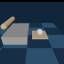

In [3]:
# print(f"traj {traj_id}, agent time: {traj['info_agent_time']}, env time: {traj['info_env_time']}, total time: {traj['info_total_time']}")
from plb.utils.visualization_utils import save_numpy_as_gif
import numpy as np
save_numpy_as_gif(np.array(traj['obses']), filename)

from IPython.display import Image
Image(filename)

In [16]:
actions = traj['actions']
print(actions.shape)

filename = 'data/env_modeling/solve_lift_reset.gif'
new_traj = sample_traj(env, solver, reset_key, action_sequence=actions)
save_numpy_as_gif(np.array(traj['obses']), filename)
Image(filename)

(50, 12)


AssertionError: 